## Topic: Scraping and analysing data of Smartphone products from the Lazada E-Commerce
## Important note: Please use the dataset attached with the files to run the data, since all analyses in this notebook are based on that dataset, running the scraping function may result in an updated dataset, hence altering the input of the analyses

## Part 1: Background
### Why This Project:
The decision to undertake this project stems from the growing significance of e-commerce in the retail landscape, particularly in the smartphone industry. Lazada, being a prominent player in the online marketplace, offers a rich dataset that can be harnessed to understand evolving consumer preferences, pricing strategies, and the overall market trajectory. By delving into Lazada's smartphone sales data, our team seeks to uncover actionable intelligence that can guide business decisions and strategies in this dynamic market.

### Project Objectives:
1. **Market Trends Analysis**: Explore and identify trends in smartphone sales, including popular brands, models, and key features driving consumer demand.
2. **Sales Prediction**: By using Random Forest, we aim to identify key features that impact the sales of each product

## Part 2: Data Scraping
### 2.1: Scraping data from Lazada using GET request
In order to scrape data from Lazada, we take advantage of the **GET request method**. Essentially, by using the inspection tool built in the browser, we have discovered that Lazada’s data source of a web page can be accessed by adding **ajax=true** in the URL. When you add *ajax=true* to a URL request, it often indicates that you are trying to fetch data from a web page that relies on AJAX (Asynchronous JavaScript and XML) to dynamically load or update content. AJAX is a technology commonly used in web development to allow web pages to retrieve and send data to a server asynchronously, without requiring a full page reload.

Many modern websites use AJAX to load data dynamically without refreshing the entire page. When you set *ajax=true*, you are signaling to the server that you want the data source directly, which is often in a structured format like JSON (JavaScript Object Notation) rather than the fully rendered HTML page.

By harnessing the power of the GET request method, we have developed a tool to scrape data using search keywords. For example, in order to scrape data for smartphones product, we can enter the word **”smartphone”**, which is quite similar to when we search for products on the Lazada platform. Notice that the scraped data is not the same each time since the platform may add, update or remove products through time

### 2.2 Constraints
Lazada has an anti-scraping mechanism, which is often found in many websites today. It blocks the access of the IP address if it exceeds 50 requests, which means after scraping 50 pages in Lazada, the tool stops and the IP address has to wait for a certain period (1-3 days) before accessing it again. A good method to overcome this issue is to use **rotating proxy**, which means the browser changes the proxy after a certain period, thus bypassing the anti-scraping mechanism. In this project, we provide the complete code to run the scraping step assuming there is no anti-scraping mechanism. However we only proceed to scrape 50 pages of Lazada, equalling to around 2000 items being scraped (40 items per page)

In [1]:
# import necessary libraries
import requests
import json
import pandas as pd
import math
import random
import time
from urllib.parse import quote
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
import folium
from folium.plugins import HeatMap
from sklearn.linear_model import SGDRegressor, Lasso, ElasticNet, Ridge
from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from multiprocessing import Pool
from collections import Counter
from abc import ABC,abstractmethod

In [67]:
# create a simple user command to enter keyword
keyword = str(input('Input keyword here: '))
keyword = quote(keyword)
base_url = 'https://www.lazada.vn/catalog/?ajax=true&page=1&q='+keyword
url = 'https://www.lazada.vn/catalog/?ajax=true&page={}&q='+keyword

Input keyword here:  dien thoai di dong


This block of code is used to generate urls to scrape from, from page 1 to the last page of the results, see below for visualization\
**len(urls)** will return the number of urls generated, in the case of the IP addreess being blocked, it will return this error:
JSONDecodeError: Expecting value: line 1 column 1 (char 0)

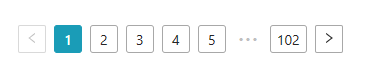

In [68]:
headers = {
    'user-agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36 Edg/118.0.2088.61'
}
# 'totalResults' shows how many products are found when the keyword is entered (to find out more please use this url to check)
# this url is used as an example of the data source that the request function will get from 
# https://www.lazada.vn/catalog/?ajax=true&page=1&q=dien-thoai-di-dong
req = requests.get(base_url, headers=headers).json()
total_product = int(req['mainInfo']['totalResults'])
total_page = math.ceil(total_product/40)
# for i in range(1, total_page+1): is used if there is no anti-scraping mechanism. In this case we only run through 50 urls only
urls = []
#for i in range(1, total_page+1):
for i in range(1,51):
    url = url.format(i)
    urls.append(url)
len(urls)

50

In the next step we create a scrape function to extract data from the data source. Through trials and errors, we notice that there are some elements such as discount and items_sold may not be displayed in some items, may be it does not have a discount or the seller has not sold any items. Therefore we wrapped those elements in try except block, and assign them an approprate value or tag and clean the data later

In [69]:
# creating a scrape function
def scrape(url):
    req = requests.get(url, headers=headers).json()
    rows = req['mods']['listItems']
    product_list = []
    for i in range(0,len(rows)):
        product_ID          = rows[i]['itemId']
        product_name    = rows[i]['name']
        price           = rows[i]['price']
        try:
            original_price  = rows[i]['originalPrice']
            discount        = rows[i]['discount']
        except:
            original_price  = rows[i]['price']
            discount        = "0% Off"
        try:
            items_sold      = rows[i]['itemSoldCntShow']
        except:
            items_sold      = 'NA'
        brand_ID        = rows[i]['brandId']
        brand_name      = rows[i]['brandName']
        seller_ID       = rows[i]['sellerId']
        try:
            seller_name     = rows[i]['sellerName']
        except:
            seller_name     = 'NA'
        location        = rows[i]['location']
        rating          = rows[i]['ratingScore']
        review          = rows[i]['review']
        product_list.append(
            (product_ID, product_name, price, original_price, discount, items_sold, brand_ID, brand_name, seller_ID, seller_name, location, rating, review)
        )
    return product_list

Next, we created a loop to run the function. We have added several elements such as **time.sleep** so that the tool acts more like a normal person with random intervals between requests. By that way we can bypass the robot detection algorithm. We also added UI elements to inform users about the scrapping progress. A try except loop is added to preserve the scraped data when the tool is intercepted by the anti-scraping algorithm. After that the data is exported to an excel file.
In reality, the export step is not necessary but in our cases due to the tool being interrupted too many times we had to run the tool multiple times and merge the data into one complete file. It also explains why in our data there is more than 2000 items since we have scraped more than 50 pages.

In [ ]:
total_product_list = []
for i in range(0,len(urls)):
    try:
        page_product = scrape(urls[i])
        time.sleep(random.randint(2,5))
        total_product_list.extend(page_product)
        loading = i/len(urls)
        print('Scraping')
        print((format(loading,'.0%')))
    except:
        print('Scrapping stopped, dumping data')
df =  pd.DataFrame(total_product_list,columns=['product_ID', 'product_name', 'price', 'original_price', 'discount', 'items_sold', 'brand_ID', 'brand_name', 'seller_ID', 'seller_name', 'location', 'rating', 'review'])
df.to_excel('midterm_data.xlsx')

## Part 3: Data Cleaning
### 3.1: Automatical cleaning
In this step we base on standard cleaning procedure to clean data such as removing unnecessary column, changing data format, eliminating non-valid values. We have investigated and found out that there are 3 items with 0 reviews don't have rating, and we don't have information to fill the missing value, despite those items still have sales. Therefore we chose to eliminate these items.

In [2]:
df = pd.read_excel('midterm_data.xlsx')
df.head(2)

,Unnamed: 0,product_ID,product_name,price,original_price,discount,items_sold,brand_ID,brand_name,seller_ID,seller_name,location,rating,review
0,0,2016216850,iPhone 14 Pro Max - Hàng Chính Hãng VN/A,28889000,36990000,22% Off,"9,032 sold",69,Apple,1000001033,Apple Flagship Store,Hồ Chí Minh,4.871741,959.0
1,1,2232879162,Điện thoại Samsung Galaxy A34 5G ( 8GB - 128GB...,6649000,8490000,22% Off,"1,106 sold",934,Samsung,100012082,HAPPY PHONE,Hồ Chí Minh,4.886463,229.0


In [3]:
# We have to drop_duplicates because Lazada frequently displaying certain products from one page to another page
df = pd.read_excel('midterm_data.xlsx')
df.drop_duplicates(subset=['product_ID'], keep='first', inplace=True)
# Deleted columns Unnamed: 0
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Changed product_ID, brand_ID, seller_ID to dtype str
df['product_ID'] = df['product_ID'].astype('str')
df['brand_ID'] = df['brand_ID'].astype('str')
df['seller_ID'] = df['seller_ID'].astype('str')

# Changed discount to dtype int
df['discount'] = df['discount'].str.replace('% Off', '').astype('int')
df.rename(columns={'discount': 'discount_(%)'}, inplace=True)

# Changed review to dtype int
df['review'] = df['review'].fillna(0).astype('int')

# Changed items_sold to dtype int
df.fillna({'items_sold': '0 sold'}, inplace=True)
df['items_sold'] = df['items_sold'].str.replace(',','',regex=False).str.replace(' sold','',regex=False).str.replace('+','',regex=False).astype('int')

# Round Rating value to 2 decimals
df['rating'] = df['rating'].round(2)

# Remove items with 0 sold 
df = df[df['items_sold'] != 0]

# Remove items with 0 review
df = df[df['review'] != 0]

df.head(5)

,product_ID,product_name,price,original_price,discount_(%),items_sold,brand_ID,brand_name,seller_ID,seller_name,location,rating,review
0,2016216850,iPhone 14 Pro Max - Hàng Chính Hãng VN/A,28889000,36990000,22,9032,69,Apple,1000001033,Apple Flagship Store,Hồ Chí Minh,4.87,959
1,2232879162,Điện thoại Samsung Galaxy A34 5G ( 8GB - 128GB...,6649000,8490000,22,1106,934,Samsung,100012082,HAPPY PHONE,Hồ Chí Minh,4.89,229
2,2200180452,Điện thoại Xiaomi Redmi 12C | MediaTek Helio G...,1970000,3190000,38,9999,4348,Xiaomi,200164404184,Xiaomi Brand Store,Hồ Chí Minh,4.96,2038
3,1525577176,iPhone 13 - VN/A Authentic Product,16189000,24990000,35,4483,69,Apple,1000001033,Apple Flagship Store,Hồ Chí Minh,4.89,942
4,2417254495,iPhone 15 Plus - Hàng Chính Hãng VN/A,24990000,25990000,4,127,69,Apple,1000001033,Apple Flagship Store,Bắc Ninh,5.00,15


In [4]:
print(df.isnull().any())

product_ID        False
product_name      False
price             False
original_price    False
discount_(%)      False
items_sold        False
brand_ID          False
brand_name        False
seller_ID         False
seller_name       False
location          False
rating            False
review            False
dtype: bool


Next we check the statistics of the data. Pandas has its own **DataFrame.describe()** function but we will make our own version of the function

In [5]:
def describe(df):
    desc_dict = {}
    
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            desc_dict[column] = {
                'count': df[column].count(),
                'mean': df[column].mean(),
                'std': df[column].std(),
                'min': df[column].min(),
                '25%': df[column].quantile(0.25),
                '50%': df[column].quantile(0.5),
                '75%': df[column].quantile(0.75),
                'max': df[column].max()
            }
    
    return pd.DataFrame(desc_dict)

# Use the function on the DataFrame
describe_df = describe(df).applymap("{0:.5f}".format)
print(describe_df)

                price  original_price discount_(%)  items_sold      rating  \
count      1189.00000      1189.00000   1189.00000  1189.00000  1189.00000   
mean    1764448.66358   2652888.22540     39.25063   118.28343     4.93961   
std     3783759.67580   4800389.20958     13.58268   558.58794     0.13050   
min        5100.00000      5100.00000      0.00000     5.00000     4.00000   
25%      549000.00000    977000.00000     39.00000    35.00000     4.93000   
50%      883898.00000   1599000.00000     44.00000    46.00000     5.00000   
75%     1299000.00000   2288000.00000     48.00000    74.00000     5.00000   
max    35290000.00000  40990000.00000     57.00000  9999.00000     5.00000   

           review  
count  1189.00000  
mean     48.67452  
std      95.39384  
min       1.00000  
25%      25.00000  
50%      36.00000  
75%      52.00000  
max    2038.00000  


The given statistics represent a summary of a dataset with six columns: price, original_price, discount_(%), items_sold, rating, and review. 
Here's an analysis for each column:

**Price:** The average price of the items is approximately 1,764,448.66 VND, with a standard deviation of 3,783,759.68 VND, indicating a wide spread of prices. The minimum price is 5,100 VND, and the maximum price is 35,290,000 VND. The 25th, 50th (median), and 75th percentiles are 549,000 VND, 883,898 VND, and 1,299,000 VND, respectively, suggesting that half of the prices lie between 549,000 and 1,299,000 VND.

**Original_Price**: The average original price is approximately 2,652,888.23 VND, with a standard deviation of 4,800,389.21 VND, indicating a wide range of original prices. The minimum and maximum original prices are the same as the price column. The 25th, 50th, and 75th percentiles are 977,000 VND, 1,599,000 VND, and 2,288,000 VND, respectively.

**Discount_(%)**: The average discount offered is approximately 39.25%, with a standard deviation of 13.58%, indicating a moderate variability in discounts. The minimum discount is 0%, and the maximum discount is 57%. The 25th, 50th, and 75th percentiles are 39%, 44%, and 48%, respectively.

**Items_Sold**: The average number of items sold is approximately 118.28, with a high standard deviation of 558.59, indicating a large variability in the number of items sold. The minimum number of items sold is 5, and the maximum is 9,999. The 25th, 50th, and 75th percentiles are 35, 46, and 74, respectively.

**Rating**: The average rating is approximately 4.94 (on a scale presumably up to 5), with a small standard deviation of 0.13, indicating that ratings are generally high and do not vary much. The minimum rating is 4, and the maximum rating is 5. The 25th, 50th, and 75th percentiles are 4.93, 5, and 5, respectively.

**Review**: The average number of reviews is approximately 48.67, with a high standard deviation of 95.39, indicating a large variability in the number of reviews. The minimum number of reviews is 1, and the maximum is 2,038. The 25th, 50th, and 75th percentiles are 25, 36, and 52, respectively.

#### It can be seen that there are some outlier in the dataset. However, these are called Natural Outliers as they exists due to objective reasons. In this case, a phone can have an astonishing sales number due to its great value/price ratio. Hence, these outliers are not eliminated to ensure the objectivity of the dataset

### 3.2: Manual Cleaning

We have notice several anomalies in the statistics, such as items with price under 100,000VND. In reality, a functional phone usually costs more than 100,000, we've also found out that items that are under this price are phone cases, therefore, we chose to opt out these items in the dataset. 

Through manual inspection, we've also found out that there are some brands that are misspelled. Therefore we have made some changes to the brand_name column so that it can project the data more accurately

In [86]:
df['brand_name'].unique()

array(['Apple', 'Samsung', 'Xiaomi', 'OPPO', 'Tecno', 'No Brand', 'Nokia',
       'Itel', 'Vivo', 'Meizu', 'basica', 'Realme', 'Sharp', 'Google',
       'Huawei', 'vsmart', 'nubia', 'Bphone', 'Vietnamobile', 'LG',
       'LG Hausys', 'Sony', 'Nobard', 'One Plus'], dtype=object)

In [87]:
df = df[df['price'].gt(100000)]

df['brand_name'] = df['brand_name'].replace('LG Hausys','LG')
df['brand_name'] = df['brand_name'].replace('Nobard','No Brand')
df.head(2)

,product_ID,product_name,price,original_price,discount_(%),items_sold,brand_ID,brand_name,seller_ID,seller_name,location,rating,review
0,2016216850,iPhone 14 Pro Max - Hàng Chính Hãng VN/A,28889000,36990000,22,9032,69,Apple,1000001033,Apple Flagship Store,Hồ Chí Minh,4.87,959
1,2232879162,Điện thoại Samsung Galaxy A34 5G ( 8GB - 128GB...,6649000,8490000,22,1106,934,Samsung,100012082,HAPPY PHONE,Hồ Chí Minh,4.89,229


### 3.3: Double-checking the data

In [88]:
# Double-checking the data
describe_df = describe(df).applymap("{0:.5f}".format)
print(describe_df)

                price  original_price discount_(%)  items_sold      rating  \
count      1177.00000      1177.00000   1177.00000  1177.00000  1177.00000   
mean    1782035.73577   2679423.70433     39.54036   117.78250     4.94126   
std     3798979.09772   4817574.78071     13.24528   560.98995     0.12845   
min      230055.00000    265000.00000      0.00000     5.00000     4.00000   
25%      549000.00000    979000.00000     39.00000    35.00000     4.93000   
50%      895000.00000   1599000.00000     44.00000    45.00000     5.00000   
75%     1301165.00000   2288000.00000     48.00000    73.00000     5.00000   
max    35290000.00000  40990000.00000     57.00000  9999.00000     5.00000   

           review  
count  1177.00000  
mean     48.79694  
std      95.83104  
min       1.00000  
25%      25.00000  
50%      36.00000  
75%      52.00000  
max    2038.00000  


**Price**: The average price of the items is approximately 1,782,035.74 VND, with a standard deviation of 3,798,979.10 VND, indicating a wide spread of prices. The minimum price is 230,055 VND, and the maximum price is 35,290,000 VND. The 25th, 50th (median), and 75th percentiles are 549,000 VND, 895,000 VND, and 1,301,165 VND, respectively, suggesting that half of the prices lie between 549,000 and 1,301,165 VND.

**Original_Price**: The average original price is approximately 2,679,423.70 VND, with a standard deviation of 4,817,574.78 VND, indicating a wide range of original prices. The minimum original price is 265,000 VND, and the maximum original price is 40,990,000 VND. The 25th, 50th, and 75th percentiles are 979,000 VND, 1,599,000 VND, and 2,288,000 VND, respectively.

**Discount_(%)**: The average discount offered is approximately 39.54%, with a standard deviation of 13.25%, indicating a moderate variability in discounts. The minimum discount is 0%, and the maximum discount is 57%. The 25th, 50th, and 75th percentiles are 39%, 44%, and 48%, respectively.

**Items_Sold**: The average number of items sold is approximately 117.78, with a high standard deviation of 560.99, indicating a large variability in the number of items sold. The minimum number of items sold is 5, and the maximum is 9,999. The 25th, 50th, and 75th percentiles are 35, 45, and 73, respectively.

**Rating**: The average rating is approximately 4.94 (on a scale presumably up to 5), with a small standard deviation of 0.13, indicating that ratings are generally high and do not vary much. The minimum rating is 4, and the maximum rating is 5. The 25th, 50th, and 75th percentiles are 4.93, 5, and 5, respectively.

**Review**: The average number of reviews is approximately 48.80, with a high standard deviation of 95.83, indicating a large variability in the number of reviews. The minimum number of reviews is 1, and the maximum is 2,038. The 25th, 50th, and 75th percentiles are 25, 36, and 52, respectively.

In summary, the dataset shows a wide range of prices and original prices in VND, a moderate range of discounts, a large variability in the number of items sold and reviews, and high ratings with little variability.

In [89]:
# Double checking the brand_name column
df['brand_name'].unique()

array(['Apple', 'Samsung', 'Xiaomi', 'OPPO', 'Tecno', 'No Brand', 'Nokia',
       'Itel', 'Vivo', 'Meizu', 'Realme', 'Sharp', 'Google', 'Huawei',
       'vsmart', 'nubia', 'Bphone', 'LG', 'Sony', 'One Plus'],
      dtype=object)

## Part 4: Data Analysis

In [90]:
# Dividing the dataset into category features and numerical features
category_features = ['product_ID', 'brand_name', 'seller_name', 'location']
number_analyze = ['price', 'original_price', 'discount_(%)', 'items_sold', 'rating', 'review']
number_features = ['price', 'original_price', 'discount_(%)', 'rating', 'review']
features= category_features + number_features
target = ['items_sold']

In [91]:
# describing numerical data
numdescribe_df = describe(df[number_analyze]).applymap("{0:.5f}".format)
numdescribe_df

,price,original_price,discount_(%),items_sold,rating,review
count,1177.00000,1177.00000,1177.00000,1177.00000,1177.00000,1177.00000
mean,1782035.73577,2679423.70433,39.54036,117.78250,4.94126,48.79694
std,3798979.09772,4817574.78071,13.24528,560.98995,0.12845,95.83104
min,230055.00000,265000.00000,0.00000,5.00000,4.00000,1.00000
25%,549000.00000,979000.00000,39.00000,35.00000,4.93000,25.00000
50%,895000.00000,1599000.00000,44.00000,45.00000,5.00000,36.00000
75%,1301165.00000,2288000.00000,48.00000,73.00000,5.00000,52.00000
max,35290000.00000,40990000.00000,57.00000,9999.00000,5.00000,2038.00000


**Price**: The average price of the items is approximately 1,782,035.74 VND, with a standard deviation of 3,798,979.10 VND, indicating a wide spread of prices. The minimum price is 230,055 VND, and the maximum price is 35,290,000 VND. The 25th, 50th (median), and 75th percentiles are 549,000 VND, 895,000 VND, and 1,301,165 VND, respectively, suggesting that half of the prices lie between 549,000 and 1,301,165 VND.

**Original_Price**: The average original price is approximately 2,679,423.70 VND, with a standard deviation of 4,817,574.78 VND, indicating a wide range of original prices. The minimum original price is 265,000 VND, and the maximum original price is 40,990,000 VND. The 25th, 50th, and 75th percentiles are 979,000 VND, 1,599,000 VND, and 2,288,000 VND, respectively.

**Discount_(%)**: The average discount offered is approximately 39.54%, with a standard deviation of 13.25%, indicating a moderate variability in discounts. The minimum discount is 0%, and the maximum discount is 57%. The 25th, 50th, and 75th percentiles are 39%, 44%, and 48%, respectively.

**Items_Sold**: The average number of items sold is approximately 117.78, with a high standard deviation of 560.99, indicating a large variability in the number of items sold. The minimum number of items sold is 5, and the maximum is 9,999. The 25th, 50th, and 75th percentiles are 35, 45, and 73, respectively.

**Rating**: The average rating is approximately 4.94 (on a scale presumably up to 5), with a small standard deviation of 0.13, indicating that ratings are generally high and do not vary much. The minimum rating is 4, and the maximum rating is 5. The 25th, 50th, and 75th percentiles are 4.93, 5, and 5, respectively.

**Review**: The average number of reviews is approximately 48.80, with a high standard deviation of 95.83, indicating a large variability in the number of reviews. The minimum number of reviews is 1, and the maximum is 2,038. The 25th, 50th, and 75th percentiles are 25, 36, and 52, respectively.

In summary, the dataset shows a wide range of prices and original prices in VND, a moderate range of discounts, a large variability in the number of items sold and reviews, and high ratings with little variability.

In [92]:
# Describing categorical data
for col in category_features:
    df[col] = df[col].astype('category')
print(df[category_features].describe())

        product_ID brand_name     seller_name     location
count         1177       1177            1177         1177
unique        1177         20             110           16
top     1011280524       OPPO  Thống Nhất 001  Hồ Chí Minh
freq             1        543             338         1056


**Product_ID**: There are 1,177 unique product IDs in the dataset, each appearing only once (frequency of 1). This suggests that each product ID is unique and represents a different product.

**Brand_Name**: There are 20 unique brand names in the dataset. The most frequent brand is OPPO, appearing 543 times. This suggests that OPPO is the most common brand in this dataset.

**Seller_Name**: There are 110 unique sellers in the dataset. The most frequent seller is 'Thống Nhất 001', appearing 338 times. This suggests that 'Thống Nhất 001' is the most common seller in this dataset.

**Location**: There are 16 unique locations in the dataset. The most frequent location is 'Hồ Chí Minh', appearing 1,056 times. This suggests that 'Hồ Chí Minh' is the most common location for sellers in this dataset.

In summary, the dataset shows a wide variety of products, brands, sellers, and locations. The most common brand is OPPO, the most common seller is 'Thống Nhất 001', and the most common location is 'Hồ Chí Minh'.

[Text(0, 0.5, 'Review'), Text(0.5, 1.0, 'Box Plot On Review')]

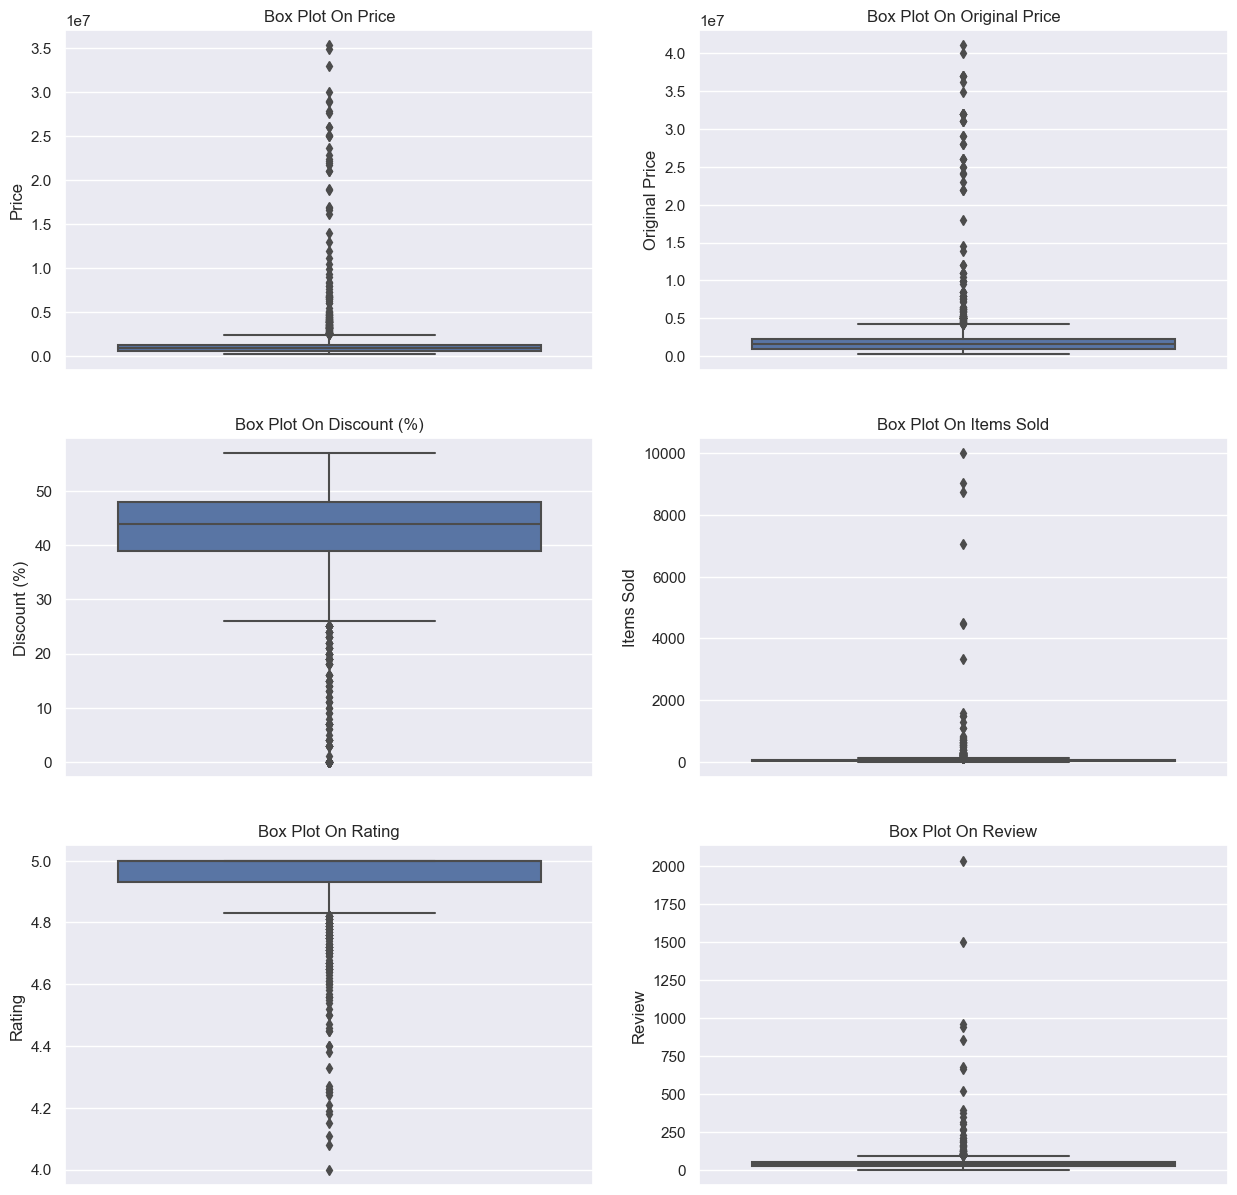

In [93]:
sns.set(font_scale=1.0)
fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(15, 15)
sns.boxplot(data=df,y="price",orient="v",ax=axes[0][0])
sns.boxplot(data=df,y="original_price",orient="v",ax=axes[0][1])
sns.boxplot(data=df,y="discount_(%)",orient="v",ax=axes[1][0])
sns.boxplot(data=df,y="items_sold",orient="v",ax=axes[1][1])
sns.boxplot(data=df,y="rating",orient="v",ax=axes[2][0])
sns.boxplot(data=df,y="review",orient="v",ax=axes[2][1])

axes[0][0].set(ylabel='Price',title="Box Plot On Price")
axes[0][1].set(ylabel='Original Price',title="Box Plot On Original Price")
axes[1][0].set(ylabel='Discount (%)',title="Box Plot On Discount (%)")
axes[1][1].set(ylabel='Items Sold',title="Box Plot On Items Sold")
axes[2][0].set(ylabel='Rating',title="Box Plot On Rating")
axes[2][1].set(ylabel='Review',title="Box Plot On Review")

#### Run 3 blocks below to view boxplot at a larger scale

In [ ]:
# Box plot for Price and Original price
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[15, 20])
sns.boxplot(data=df, y="price", orient="v", ax=axes[0])
axes[0].set(ylabel='Price', title="Box Plot On Price")
sns.boxplot(data=df, y="original_price", orient="v", ax=axes[1])
axes[1].set(ylabel='Original Price', title="Box Plot On Original Price")

In [ ]:
# Box plot for Discount and Items Sold
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[15, 20])
sns.boxplot(data=df, y="discount_(%)", orient="v", ax=axes[0])
axes[0].set(ylabel='Discount (%)', title="Box Plot On Discount (%)")
sns.boxplot(data=df, y="items_sold", orient="v", ax=axes[1])
axes[1].set(ylabel='Items Sold', title="Box Plot On Items Sold")

In [ ]:
# Box plot for Rating and Review
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[15, 20])

sns.boxplot(data=df, y="rating", orient="v", ax=axes[0])
axes[0].set(ylabel='Rating', title="Box Plot On Rating")

sns.boxplot(data=df, y="review", orient="v", ax=axes[1])
axes[1].set(ylabel='Review', title="Box Plot On Review")

plt.tight_layout()
plt.show()

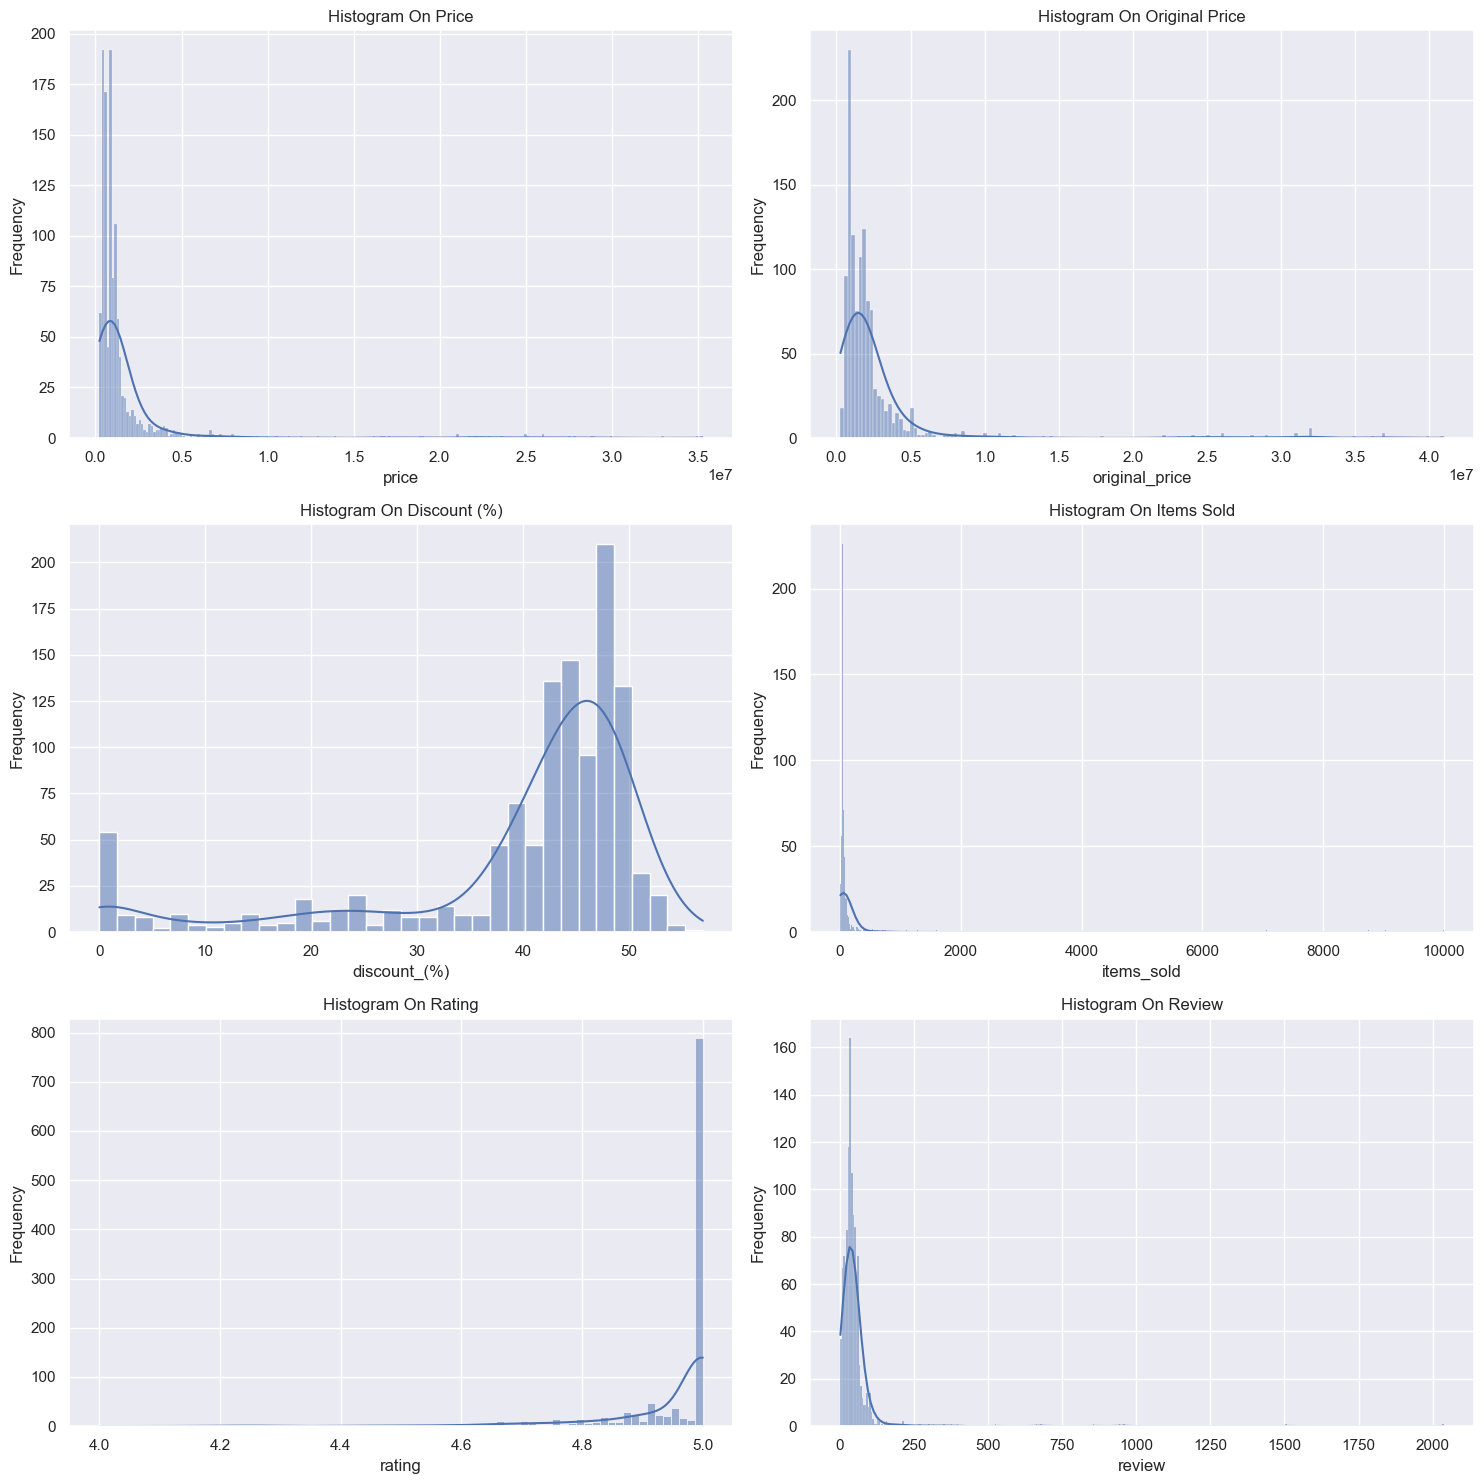

In [94]:
# Histograms for columns
sns.set(font_scale=1.0)
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(15, 15)

sns.histplot(data=df, x="price", kde=True, ax=axes[0][0])
sns.histplot(data=df, x="original_price", kde=True, ax=axes[0][1])
sns.histplot(data=df, x="discount_(%)", kde=True, ax=axes[1][0])
sns.histplot(data=df, x="items_sold", kde=True, ax=axes[1][1])
sns.histplot(data=df, x="rating", kde=True, ax=axes[2][0])
sns.histplot(data=df, x="review", kde=True, ax=axes[2][1])

axes[0][0].set(ylabel='Frequency', title="Histogram On Price")
axes[0][1].set(ylabel='Frequency', title="Histogram On Original Price")
axes[1][0].set(ylabel='Frequency', title="Histogram On Discount (%)")
axes[1][1].set(ylabel='Frequency', title="Histogram On Items Sold")
axes[2][0].set(ylabel='Frequency', title="Histogram On Rating")
axes[2][1].set(ylabel='Frequency', title="Histogram On Review")

plt.tight_layout()
plt.show()

- Comment on **price** and **orginal_price**:
	* The mean of “price” and “orginal_price” are roughly 1782035.73 and 2679423.7, which means the average price after discount is much lower than the original price and they are higher value than more 75% value of other mobile phones
	* The mean mobile phone price is higher than the median indicating that there are some high-priced residences in the dataset that are pushing the mean up.
	* The median of “price” and “orginal_price” are 895000 and 1599000, which is less influenced by extreme values, and represents the distribution's center. If it is less than the mean, it means that the majority of mobile phone prices are concentrated at the low end, with a few more-priced mobile phones contributing to the higher mean.
	* This is prevalent in datasets containing a few really high values, which can have a disproportionately large effect on the mean.
	* High-priced outliers may represent premium or luxury mobile phones with features, materials, or brand recognition that set them apart from the rest of the market.
- Comment on  **discount**:
	* The mean discount percentage is approximately 38.05%, indicating that, on average, there is a substantial discount on mobile phones.
	* The median discount percentage is around 39.5%, suggesting that the distribution of discount percentages is somewhat skewed, possibly due to outliers with very low discounts.
	* The standard deviation of approximately 13.68% implies that there is a notable amount of variability in the discount percentages. Some phones may have significant discounts, while others may have minimal discounts.
	* The outliers have very low values and are close to 0%, leading to median greater than mean.
- Comment on **item sold**:
	* The average number of products sold is around 117.78, showing that a considerable number of items are sold on average.
	* The median number of items sold is 45, implying that the distribution of goods sold is skewed, potentially due to outliers with extremely high sales. 
	* The standard deviation of roughly 560.99 indicates that the number of products sold varies significantly. Some goods may sell quite well, while others may sell very poorly.
- Comment on **Rating**:
	* The average rating of approximately 4.95 suggests a consistently positive trend. Customers generally express satisfaction with their mobile phone purchases.
	* Both the median and mode ratings are 5, indicating that a substantial majority of customers gave the highest possible rating. This dominance of top ratings reflects a high degree of contentment.
	* The standard deviation of approximately 0.28 indicates low variability in ratings. This implies that customer opinions are closely clustered around the mean, and there is a consensus of positive experiences.
	* The presence of outliers in the data, such as the lower rating of 4.19, could signify unique instances where customers had significantly different experiences compared to the overall trend of high satisfaction such as functionality, performance, or customer service.
- Comment on the **review** count:
	* The wide range of review counts, as indicated by the high standard deviation, suggests that there is significant variability in the popularity of different mobile phone products. Some products may have a substantial number of reviews, indicating high customer engagement or popularity, while others may have fewer reviews, suggesting lower visibility or demand
	* The mean of review count is approximately 48.7 greater than the median which is approximately 36 indicating the presence of extremely high review counts suggest the possibility of skewed distribution. A positively skewed distribution implies that there are a few products with exceptionally high review counts, which could be due to factors such as outstanding features, market presence, or promotional efforts.
	* Businesses could focus on improving visibility, encouraging customer feedback, or addressing potential issues to boost customer engagement and, consequently, review counts.


In [95]:
df.groupby('brand_name')['price'].describe().applymap("{0:.1f}".format)

,count,mean,std,min,25%,50%,75%,max
brand_name,,,,,,,,
Apple,20.0,22795800.0,6864613.0,10489000.0,16942500.0,22990000.0,27642500.0,35290000.0
Bphone,1.0,4350000.0,nan,4350000.0,4350000.0,4350000.0,4350000.0,4350000.0
Google,43.0,2379696.5,1860144.7,503806.0,1396168.0,1582448.0,2943999.5,9890000.0
Huawei,1.0,5999000.0,nan,5999000.0,5999000.0,5999000.0,5999000.0,5999000.0
Itel,3.0,1737333.3,858675.9,1023000.0,1261000.0,1499000.0,2094500.0,2690000.0
LG,13.0,1510973.7,701161.2,549690.0,1188000.0,1255527.0,1722158.0,2828000.0
Meizu,3.0,982316.3,346166.9,696687.0,789827.0,882967.0,1125131.0,1367295.0
No Brand,14.0,721053.9,450923.6,254092.0,325933.5,628614.0,1045242.8,1570793.0
Nokia,5.0,1076617.6,634036.1,379000.0,389000.0,1467000.0,1549000.0,1599088.0


* **Apple** - **High-End Focus**: The highest price of Apple is 35,290,000 and the lowest is 10,489,000. Apple's mean is 22,795,800 and the median is  22,990,000 which means their prices are notably higher than the average price of other brands (1,782,035.73), indicating a concentration on high-end, premium devices. This aligns with Apple's positioning as a luxury brand in the smartphone market.
* **Samsung** - **Diverse Range**: The price range of Samsung is from 300,000 to 32,990,000 Samsung offers a diverse range of smartphones, from budget to flagship models. The range of prices is relatively broad, catering to a wide consumer base. The mean is 2,782,155 and the median is 1,070,178 which means Samsung’prices are intermediate, reflecting a mix of mid-range and premium devices.
* **Xiaomi** - **Budget-Friendly Options**: The mean is 2,222,034.6 and the median is 1,784,000 which means that Xiaomi stands out for its affordability. With the lowest mean and median prices, this suggests a focus on providing cost-effective smartphones, appealing to a price-conscious consumer segment.
* **OPPO** - **Low to Mid-Range**: OPPO's mean is 844701.6 and median is 799,000 but the price max is 8,390,000 which means that prices fall in the low to mid range. This positions OPPO as a brand offering a balance between features and price, appealing to consumers looking for a mix of quality and affordability.
* **Vivo** - **Mid-Range Focus**: Vivo's mean (857,743.9) and median (743,257) prices are in the mid-range, indicating a focus on providing smartphones with decent features at a relatively affordable price. This positioning may appeal to consumers seeking a balance between performance and cost.
* **Realme** - **Budget-Friendly**: the mean and median of Realme are 1,115,284.1 and 929,537 which means Realme focuses on budget-friendly smartphones, with a capped maximum price. This strategy caters to a price-sensitive market while ensuring that even the higher-end models remain relatively affordable.
* **Google** - **Premium Positioning**: The mean of Google price is 2,379,696.5 and the median is 1,582,448 which indicates Google's single, uniform price across models suggests a premium positioning, possibly focusing on high-quality devices with consistent pricing. This approach may be related to Google's emphasis on software and user experience.
* **No Brand** - **Budget with Variability**: The "No Brand" category encompasses phones without a specific brand label. The mean is 1,076,617.6 and the median is 628614 which implies the prices are relatively lower, suggesting a budget or unbranded market segment. However, there is variability, indicating differences in quality or features among these unbranded devices.


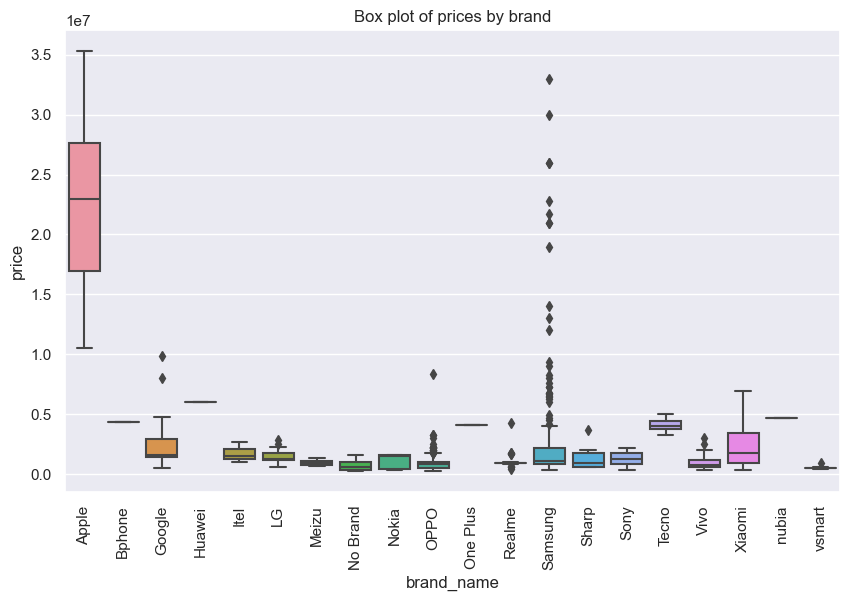

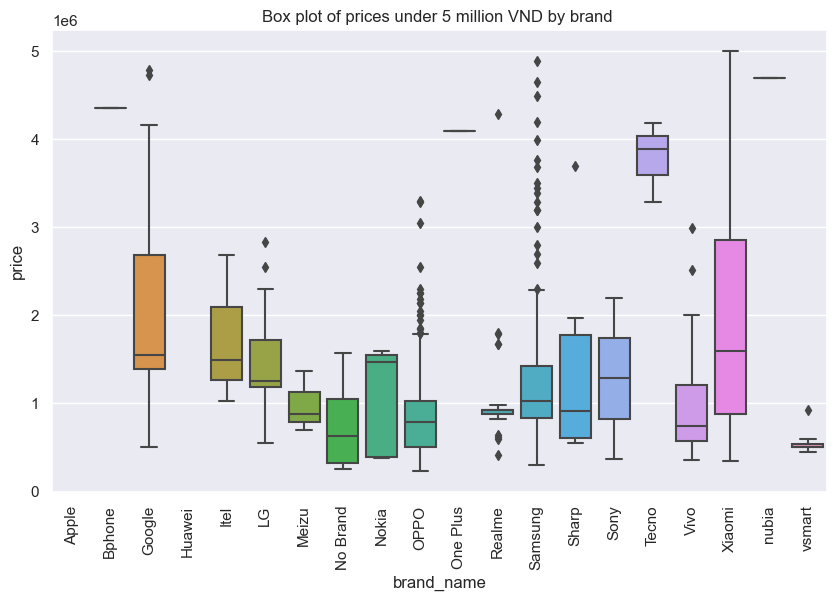

In [96]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='brand_name', y='price', data=df)
plt.title('Box plot of prices by brand')
plt.xticks(rotation=90)  # It's useful to rotate the x labels when they are string and could overlap
plt.show()

plt.figure(figsize=(10, 6))
# Filter the data
filtered_df = df[df['price'] < 5000000]

sns.boxplot(x='brand_name', y='price', data=filtered_df)

plt.title('Box plot of prices under 5 million VND by brand ')
plt.xticks(rotation=90)  # It's useful to rotate the x labels when they are string and could overlap
plt.show()

The prices of products range from 1 million VND to under 38 million VND. The most common price is under 3 million VND, while in other price ranges, there are still outliers.
Notably, Apple is the only brand with no product having price under 5 million VND

For further analysis, the brands will be divided into three categories based on prices:

* Low price (<3 million VND): Itel, LG, Sony, Nokia, Realme, Sharp, Vivo, OPPO, Meizu, No Brand, Vsmart
* Average price (3 million VND <= x <10 million VND): Huawei, OnePlus, Nubia, Tecno, Bphone, Samsung, Google, Xiaomi
* High price (>= 10 million VND): Apple

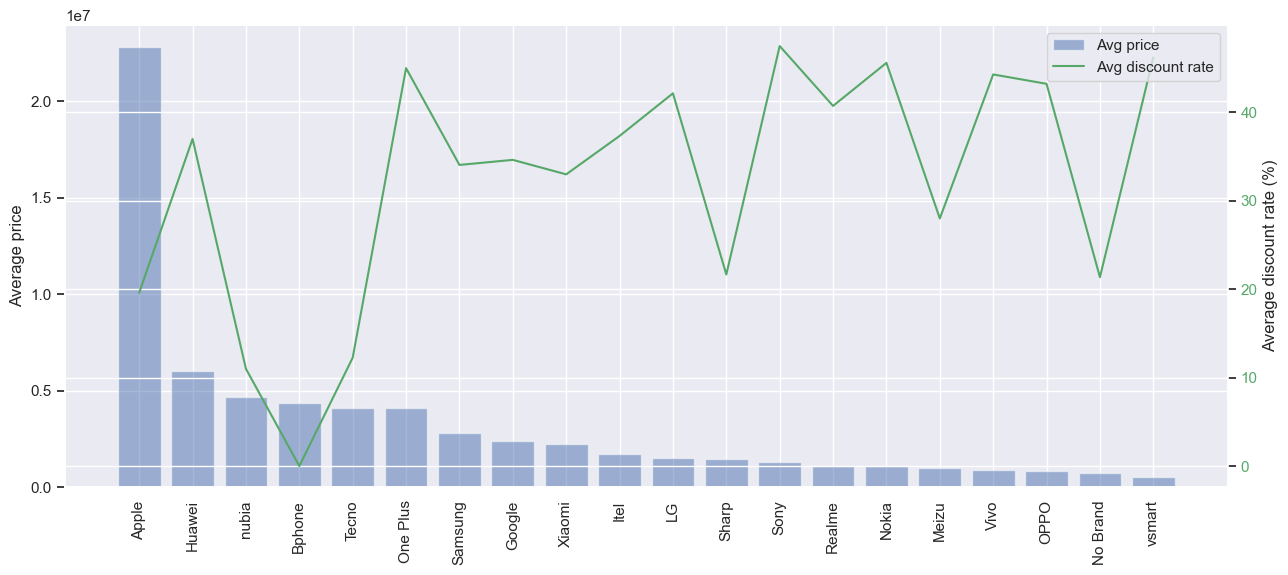

In [97]:
# Group by brand_name and calculate average discount
grouped_discount = df.groupby('brand_name')['discount_(%)'].mean()

# Group by brand_name and calculate average price, then sort
grouped_price = df.groupby('brand_name')['price'].mean().sort_values(ascending=False)

# Create a new figure with increased size for better readability
fig, ax1 = plt.subplots(figsize=(15, 6))

# Create the bar chart for average price on the first axes
ax1.bar(grouped_price.index, grouped_price, alpha=0.5, label='Avg price')
ax1.set_ylabel('Average price')
ax1.tick_params(axis='y')

# Create the line chart for average discount rate on the second (twin) axes
ax2 = ax1.twinx()
ax2.plot(grouped_price.index, grouped_discount[grouped_price.index], color='g', label='Avg discount rate')
ax2.set_ylabel('Average discount rate (%)')
ax2.tick_params(axis='y', labelcolor='g')

# Add a legend
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Rotate the x-axis labels to 90 degrees on the ax1 axes
for label in ax1.get_xticklabels():
    label.set_rotation(90)

# Show the plot
plt.show()

Among 3 categories, the Average and Low price category had the higher discounts. However, BPhone is the most unexpected brand in Average category with no discount. Sony discounted the most with the average discount of 48%, followed by Vsmart (46%) and Vivo (44%)

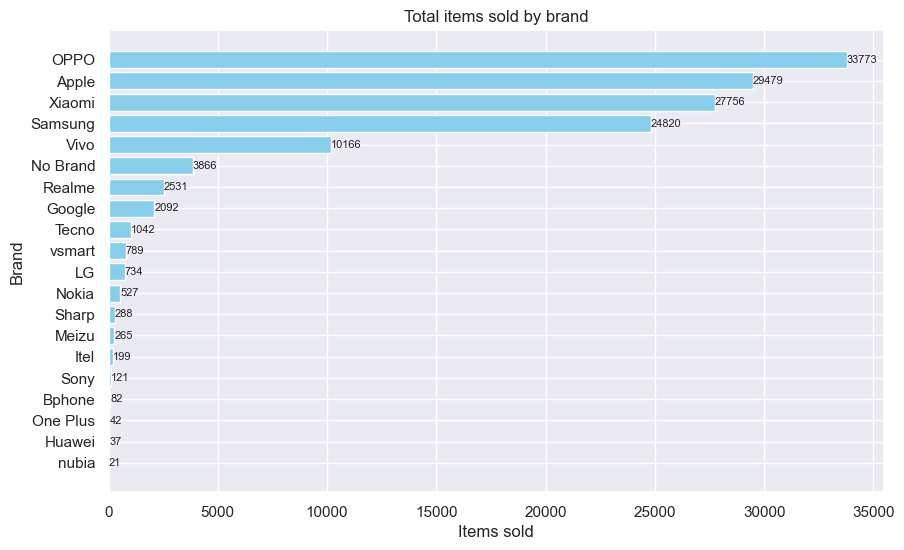

In [98]:
# Group by brand_name and calculate total items sold
grouped_df3 = df.groupby('brand_name')['items_sold'].sum().sort_values(ascending=False)

# Plot the result
plt.figure(figsize=(10, 6))
bars = plt.barh(grouped_df3.index, grouped_df3.values, color='skyblue')
plt.title('Total items sold by brand')
plt.xlabel('Items sold')
plt.ylabel('Brand')
plt.gca().invert_yaxis()  # To display the brand with the most items sold at the top

# Add data values
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.0f}', 
             va='center', ha='left', fontsize=8)

plt.show()

Oppo representing the Low category, is sold the most with 33,773 items, while Apple - representing the High category is sold with 29,479 items. In the Average category, Xiaomi and Samsung were the leaders with 27,756 and 24820 item sold respectively

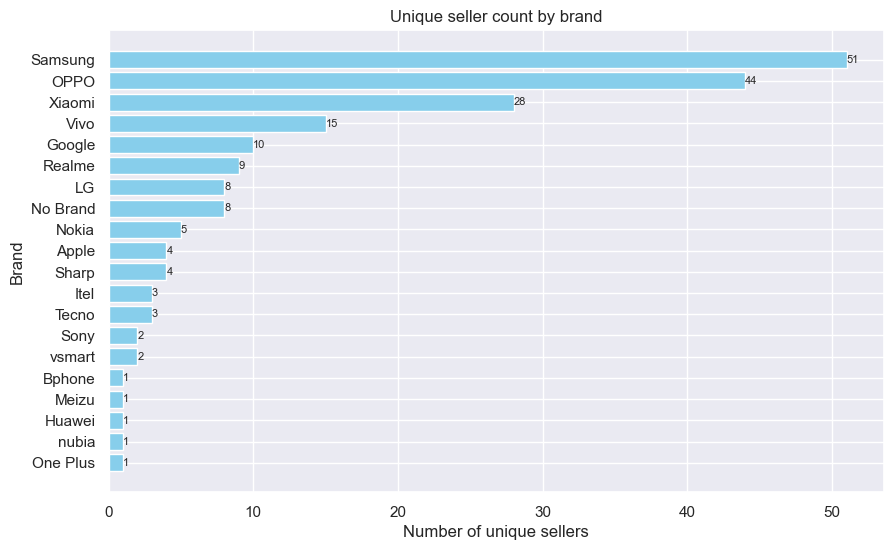

In [99]:
# Group by brand_name and calculate unique seller_ID count
grouped_df4 = df.groupby('brand_name')['seller_ID'].nunique().sort_values(ascending=False)

# Plot the result
plt.figure(figsize=(10, 6))
bars = plt.barh(grouped_df4.index, grouped_df4.values, color='skyblue')
plt.title('Unique seller count by brand')
plt.xlabel('Number of unique sellers')
plt.ylabel('Brand')
plt.gca().invert_yaxis()  # To display the brand with the most unique sellers at the top

# Add data values
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.0f}', 
             va='center', ha='left', fontsize=8)

plt.show()

These best selling brands had great numbers of sellers. The most noticeable one is Samsung which had 51 unique sellers. However, Apple was not in this case, it had only 4 sellers, one-tenth of that of Samsung but it sold through Apple Flagship store and Apple Authorized Resellers. Beside the top 5 brands with the highest amount of sellers, the remaining brands only have less than 10 sellers.

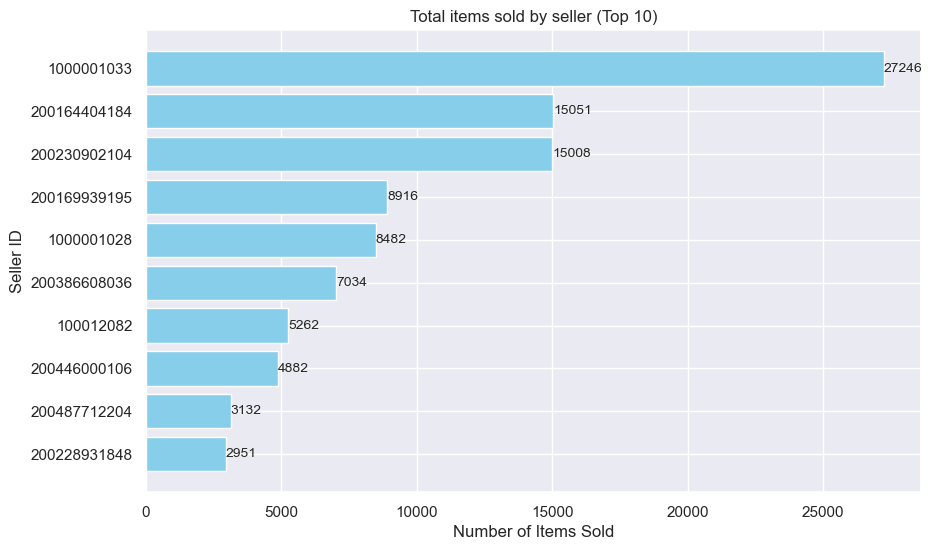

In [100]:
# Group by seller_ID and calculate total items_sold
grouped_df8 = df.groupby('seller_ID')['items_sold'].sum().sort_values(ascending=False)

# Select top 10 sellers with most items sold
top_sellers2 = grouped_df8.head(10)

# Plot the result
plt.figure(figsize=(10, 6))
bars = plt.barh(top_sellers2.index, top_sellers2.values, color='skyblue')
plt.title('Total items sold by seller (Top 10)')
plt.xlabel('Number of Items Sold')
plt.ylabel('Seller ID')
plt.gca().invert_yaxis()  # To display the seller with the most items sold at the top

# Add data values
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:d}', 
             va='center', ha='left', fontsize=10)

plt.show()

Among these sellers, the seller with ID 1000001033 sold the most with 27,246 items, nearly twice as much as the second and the third seller. That seller is the Apple Flagship Store. Combined with the graph above, it can be concluded at although Apple has few sellers, but it can still sell a lot of products.

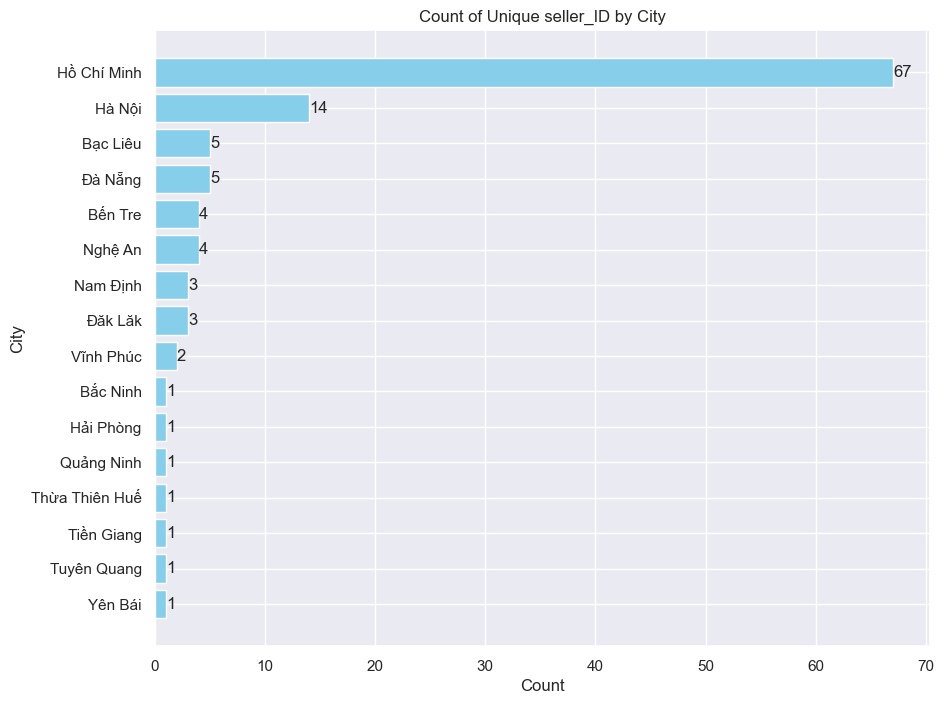

In [101]:
# Group by 'location' and count unique 'seller_ID'
grouped_df1 = df.groupby('location')['seller_ID'].nunique().sort_values(ascending=False)

# Create a horizontal bar chart
plt.figure(figsize=(10,8))
bars = plt.barh(grouped_df1.index, grouped_df1.values, color='skyblue')

# Add data labels
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             '%d' % int(bar.get_width()), ha='left', va='center')

plt.gca().invert_yaxis()  # Reverse the order of cities
plt.xlabel('Count')
plt.ylabel('City')
plt.title('Count of Unique seller_ID by City')
plt.show()

In [102]:
# Group by location and count unique seller_ID
seller_counts = df.groupby('location')['seller_ID'].nunique().reset_index()
seller_counts.columns = ['location', 'num_sellers']
seller_counts['location']

# Define a dictionary with the known longitude and latitude for each city
location_dict = {
    "Bạc Liêu": (9.2941, 105.7278),
    "Bắc Ninh": (21.1833, 106.0500),
    "Bến Tre": (10.2415, 106.3759),
    "Hà Nội": (21.0245, 105.8412),
    "Hải Phòng": (20.8648, 106.6835),
    "Hồ Chí Minh": (10.8231, 106.6297),
    "Nam Định": (20.4258, 106.1630),
    "Nghệ An": (19.2345, 104.9200),
    "Quảng Ninh": (21.0118, 107.2448),
    "Thừa Thiên Huế": (16.4637, 107.5909),
    "Tiền Giang": (10.4203, 106.1655),
    "Tuyên Quang": (21.8233, 105.2140),
    "Vĩnh Phúc": (21.3089, 105.6044),
    "Yên Bái": (21.7229, 104.9119),
    "Đà Nẵng": (16.0544, 108.2022),
    "Đăk Lăk": (12.6667, 108.0500),
}

# Add longitude and latitude columns to the dataframe
seller_counts['latitude'] = seller_counts['location'].apply(lambda x: location_dict.get(x, (None, None))[0])
seller_counts['longitude'] = seller_counts['location'].apply(lambda x: location_dict.get(x, (None, None))[1])

# Create a map centered around Vietnam
m = folium.Map(location=[14.0583, 108.2772], zoom_start=6)

# Convert seller counts to (latitude, longitude, intensity) format
heat_data = [[row['latitude'], row['longitude'], row['num_sellers']] for index, row in seller_counts.iterrows()]

# Add heatmap to map
HeatMap(heat_data).add_to(m)

# Display the map
m

Most sellers are concentrated in big cities, namely: Ho Chi Minh City, Hanoi, Da Nang and Bac Lieu. Sellers distributed along the country but concentrated in the South and the North. Nearly 59% of the number of sellers is concentrated in Ho Chi Minh City, ranked second is Ha Noi with nearly 12% of the number of sellers

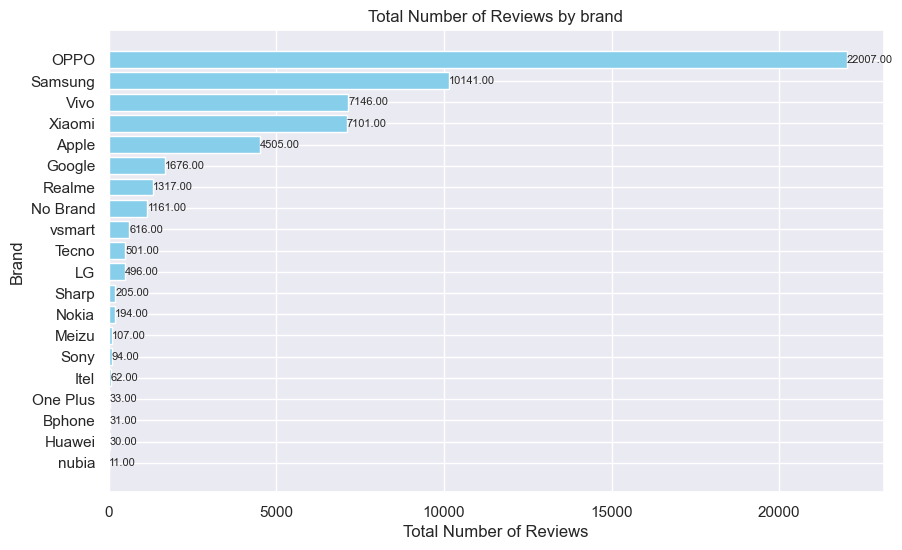

In [103]:
# Group by brand_name and calculate average review_score
grouped_df6 = df.groupby('brand_name')['review'].sum().sort_values(ascending=False)

# Plot the result
plt.figure(figsize=(10, 6))
bars = plt.barh(grouped_df6.index, grouped_df6.values, color='skyblue')
plt.title('Total Number of Reviews by brand')
plt.xlabel('Total Number of Reviews')
plt.ylabel('Brand')
plt.gca().invert_yaxis()  # To display the brand with the highest average review score at the top

# Add data values
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}', 
             va='center', ha='left', fontsize=8)

plt.show()

It is noticeable the high performing brands had a significant network of sellers. As they sold a great number of items, they had more reviews and high average ratings.
Oppo had the most significant number of reviews, of 22,007 reviews. It means 65% of the Oppo buyers had left a review after purchasing. The second highest reviewed brand - Samsung, was even less than a half of Oppo review numbers, 10,141 reviews.

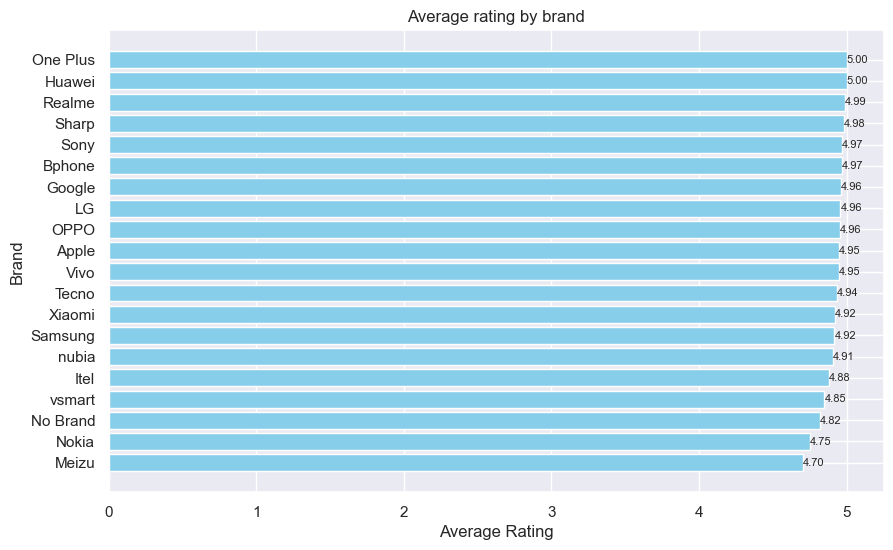

In [104]:
# Group by brand_name and calculate average rating
grouped_df5 = df.groupby('brand_name')['rating'].mean().sort_values(ascending=False)

# Plot the result
plt.figure(figsize=(10, 6))
bars = plt.barh(grouped_df5.index, grouped_df5.values, color='skyblue')
plt.title('Average rating by brand')
plt.xlabel('Average Rating')
plt.ylabel('Brand')
plt.gca().invert_yaxis()  # To display the brand with the highest average rating at the top

# Add data values
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}', 
             va='center', ha='left', fontsize=8)

plt.show()

Best selling brands from each category all had the average rating higher than 4.9/5.0. This is also the common range of all brands

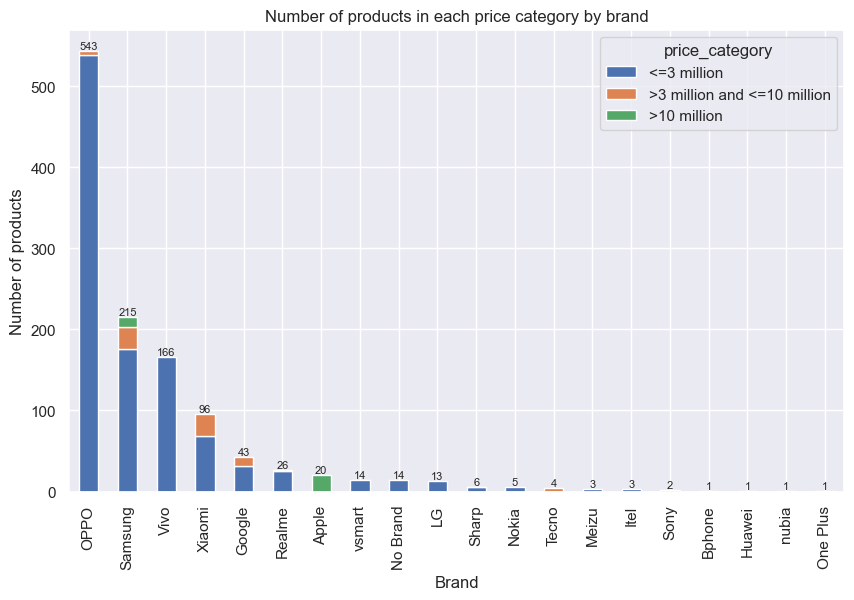

In [105]:
# Create the bins
bins = [0, 3000000, 10000000, float('inf')]
labels = ['<=3 million', '>3 million and <=10 million', '>10 million']
df['price_category'] = pd.cut(df['price'], bins=bins, labels=labels)

# Group by brand_name and price_category, and count the number of product_id's
grouped_df2 = df.groupby(['brand_name', 'price_category'])['product_ID'].count().unstack()

# Create a new column 'total' that sums up the counts across the categories for each brand
grouped_df2['total'] = grouped_df2.sum(axis=1)

# Sort the DataFrame in descending order based on the 'total' column
grouped_df2 = grouped_df2.sort_values(by='total', ascending=False)

# Plot the stacked bar graph
ax = grouped_df2.drop(columns='total').plot(kind='bar', stacked=True, figsize=(10, 6))

# Add total labels at the top of the bars
for i in range(len(grouped_df2)):
    total = grouped_df2.iloc[i]['total']
    ax.text(i, total, f'{total:.0f}', ha='center', va='bottom', fontsize=8)

plt.title('Number of products in each price category by brand')
plt.xlabel('Brand')
plt.ylabel('Number of products')
plt.xticks(rotation=90)
plt.show()

It can be seen that Oppo has the highest number of products, most of which fall into the low price category. The same thing happens to other brand, except Apple, which has products of premium price only. On the other hand, Samsung is the only brand that has products from all price range, while other brands only have products of low and medium price

## Part 5: Random Forest Regression
In this part, we are attempting to predict the items sold for each product using Random Forest Regression alongside some other model. Random Forest Regression could be useful in predicting the 'items_sold' in this dataset for several reasons:

1. **Handling Complex Relationships**: Random Forests are capable of modeling complex non-linear relationships between features and the target variable. This dataset contains multiple features such as 'price', 'original_price', 'discount_(%)', 'brand_ID', 'seller_ID', 'location', 'rating', and 'review' that could potentially have complex relationships with 'items_sold'

2. **Robust to Overfitting**: Random Forests are less prone to overfitting compared to decision trees because they aggregate the predictions of several decision trees trained on different subsets of the data

3. **Feature Importance**: Random Forests can provide a measure of the importance of each feature in predicting the target variable. This could be useful in understanding which features are most influential in determining the number of items sold

4. **Handling Categorical Variables**: Random Forests can handle categorical variables, which are present in this dataset (e.g., 'brand_name', 'seller_name', 'location')

However, it's important to note that the effectiveness of Random Forest Regression will depend on the specific characteristics of the data and the correct tuning of the model's hyperparameters. In this part, we are also going to use hyperparameter tuning to optimize the model

<Axes: >

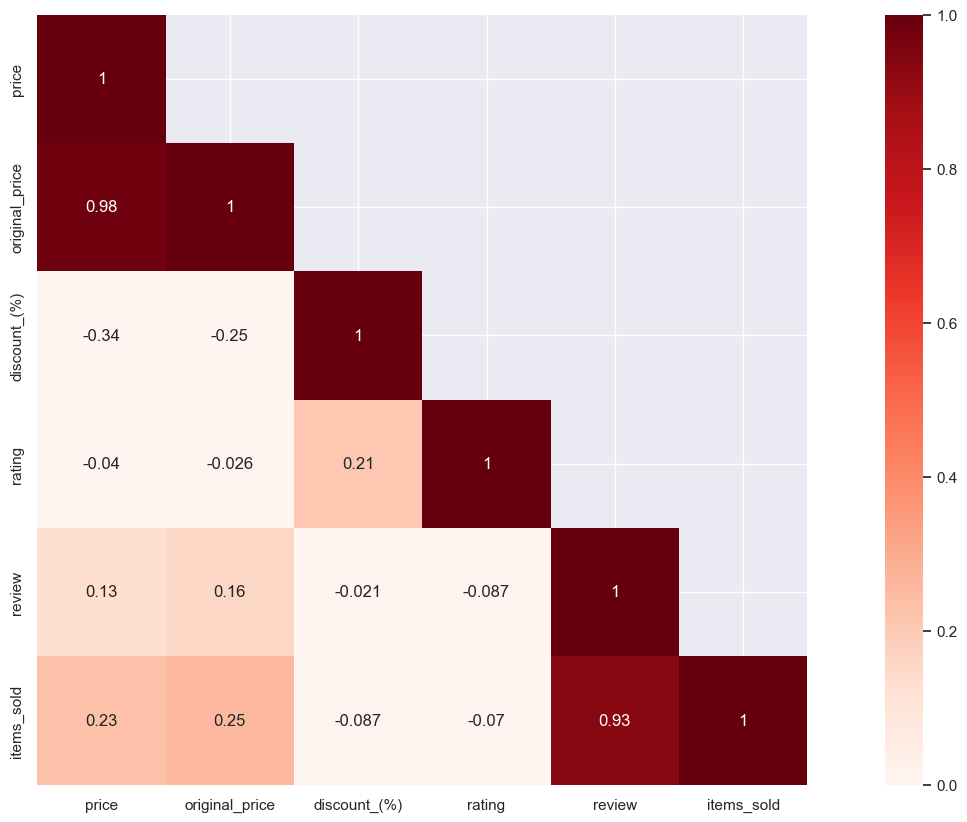

In [106]:
matrix = df[number_features + target].corr()
heat = np.array(matrix)
heat[np.tril_indices_from(heat)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.set(font_scale=1.0)
sns.heatmap(matrix, mask=heat,vmax=1.0, vmin=0.0, square=True,annot=True, cmap="Reds")

- Strong positive correlation between "items_sold" and "review" (0.93): There is a strong positive correlation between the number of items sold and the number of reviews. This is expected, as items that sell more also tend to accumulate more reviews. The correlation suggests that customers are actively engaging with the products they purchase, providing feedback through reviews. This engagement is crucial for e-commerce platforms, as it helps in building a community and providing valuable information to potential buyers
- There is a positive correlation (0.23) between “price” and "items_sold" and (0.25) between "original_price" and “item_sold”. This implies that higher-priced mobile phones tend to have higher sales, but the correlation is not very strong, the seller should consider more aspects to improve the sale and give the buyer a comfortable price.
- The correlation between “item_sold” and “rating” is -0.07 which is a negative correlation. In statistical terms, this suggests that there is little to no linear relationship between the two variables. A negative correlation between rating and sales could suggest that consumers may be less inclined to purchase mobile phones with higher ratings. This could be due to factors such as perceived high prices, overly advanced features that users might find unnecessary, or other market dynamics.
- A correlation between “item_sold” and “discount” is -0.087 which indicates a very weak negative correlation between the number of items sold and the discount of selling mobile phones, implying that there is little to no linear relationship between the two variables. In this context, consumers might not be highly responsive to discounts. It's also possible that the products being sold are not very sensitive to price changes, or that other factors, such as product features or brand reputation, are more influential in driving sales.

### Conclusion:
* **Strong positive correlation between "items_sold" and "review" (0.93)**: There is a strong positive correlation between the number of items sold and the number of reviews. This is expected, as items that sell more also tend to accumulate more reviews.
* **There is a positive correlation (0.23) between “price” and "items_sold" and (0.25) between "original_price" and “item_sold”**. This implies that higher-priced mobile phones tend to have higher sales, but the correlation is not very strong

#### As a consequence: 'Price', 'original_price', and 'review' are the promising features to speculate the items_sold

## Overview about metrics

Mean Squared Error (MSE) and R-squared (R^2) are two common metrics used to evaluate the performance of regression models.

**Mean Squared Error (MSE)**: MSE measures the average squared difference between the actual and predicted values. It is a measure of the quality of an estimator—it is always non-negative, and values closer to zero are better. A lower MSE means a better fit of the model to the data. It is particularly useful when we have unexpected values that we want to take into account because it penalizes large errors more due to the squaring

**R-squared (R^2)**: R^2, also known as the coefficient of determination, measures the proportion of the variance in the dependent variable that is predictable from the independent variables. It provides a measure of how well the model's predictions fit the actual data. An R^2 of 100% indicates that all changes in the dependent variable are completely explained by changes in the independent variables. In the context of this dataset, a high R^2 would indicate a strong relationship between the features and the target.


Using both MSE and R^2 together can provide a more comprehensive evaluation of the model's performance. While MSE provides a measure of the model's prediction error, R^2 provides a measure of the model's explanatory power.

### Formulas

MSE = ${\frac{1}{N} \sum_{i=1}^N (x_i - y_i)^2}$

$R^2=1-\frac{\sum_{i=1}^{n}e_i^2}{\sum_{i=1}^{n}(y_i-\bar{y})^2}$

In [107]:
# Defining our own MSE and R^2 function instead of relying on the library
def mean_squared_error(y_true, y_pred):
    """
    Calculate Mean Squared Error between true y and predicted y
    
    :param y_true: List of actual values
    :param y_pred: List of predicted values
    :return: Mean Squared Error
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

def r2_score(y_true, y_pred):
    """
    Calculate R^2 Score between true y and predicted y

    :param y_true: List of actual values
    :param y_pred: List of predicted values
    :return: R^2 Score
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

## Why we need to split the data into train and test set
Separating data into training and test sets is a fundamental practice in machine learning for several important reasons:

* **Model Evaluation**: The primary purpose of having a separate test set is to evaluate the performance of a machine learning model on data it has never seen before. This helps in assessing how well the model is likely to perform on new, unseen data in real-world scenarios.

* **Overfitting Detection**: When training a machine learning model, there's a risk of overfitting, where the model learns the training data too well, capturing noise and specific patterns that may not generalize to new data. The test set serves as a check against overfitting. If a model performs well on the training set but poorly on the test set, it indicates overfitting.

* **Hyperparameter Tuning**: During the development of a machine learning model, it's common to adjust hyperparameters to optimize performance. The test set helps in fine-tuning these parameters without introducing bias, as it provides an independent dataset for evaluation.

In practice, the data is often further divided into three sets: training, validation, and test sets. The training set is used to train the model, the validation set is used to fine-tune hyperparameters, and the test set is used for the final evaluation of the model's performance. This division helps ensure a more robust and reliable assessment of the model's capabilities.


In [108]:
# Defining train_test_split function
def train_test_split(X, y, test_size=0.2, random_state=None):
    """
    Split the data into train-test datasets

    :param X: List of features
    :param y: List of targets
    :param test_size: Proportion of the data to be used as test data
    :param random_state: Seed for the random number generator
    :return: Four lists (train_data_x, test_data_x, train_data_y, test_data_y)
    """
    # Set the random seed
    if random_state is not None:
        random.seed(random_state)

    # Combine X and y to shuffle
    data = list(zip(X, y))

    # Shuffle the data
    random.shuffle(data)

    # Split the data
    split_idx = int(len(data) * (1 - test_size))
    train_data = data[:split_idx]
    test_data = data[split_idx:]

    # Split the tuples into X and y lists
    train_data_x = [x for x, y in train_data]
    train_data_y = [y for x, y in train_data]
    test_data_x = [x for x, y in test_data]
    test_data_y = [y for x, y in test_data]

    return train_data_x, test_data_x, train_data_y, test_data_y

### How Random Forest Regression works
Random Forest Regression is a powerful machine learning algorithm that leverages the concept of ensemble learning to make predictions on continuous data. It operates by constructing a multitude of decision trees at training time and outputting the mean prediction of the individual trees

The process begins with the selection of random samples from the given dataset using a technique known as bootstrap aggregating, or bagging. This technique generates a number of subsets of the original data, with replacement, meaning some samples may repeat in a given subset.
For each of these subsets, a decision tree is constructed. Each tree is built by splitting nodes based on a feature that decreases the heterogeneity of the node the most. However, instead of searching for the most important feature while splitting a node, it searches for the best feature among a random subset of features. This introduces additional randomness to the model, resulting in a wide diversity that generally leads to a better model.
Each tree in the forest makes its own individual prediction. These predictions are then averaged to produce a single result. The averaging makes a Random Forest Regressor better than a single Decision Tree, improving its accuracy and reducing overfitting.
An out-of-bag sample is used as a test set to estimate the generalization error. These are the samples that were not included in the bootstrap sample for creating a tree. This provides a way to test each tree on unseen data, and to compute an unbiased estimate of the generalization error. The algorithm also provides a way to measure the importance of each feature in making predictions. This is done by looking at how much the tree nodes that use a particular feature reduce impurity on average (across all trees in the forest). Features that are often used at the top of the trees contribute to the final prediction decision of a larger fraction of the input samples, and they are therefore considered more important

### Why we need to scale the features
Feature scaling is a crucial step in the preprocessing of data before feeding it to a machine learning algorithm. It is used to standardize the range of independent variables or features of data. In this case, the features are 'price', 'original_price', and 'review'.
The main reason for scaling features in this context is that the features have different scales. For example, 'price' and 'original_price' might be in the range of hundreds to thousands, while 'review' might range from 4 to 5.
When features are on different scales, certain algorithms can give higher importance to features with a higher magnitude. This can lead to a bias in the model towards the features with larger values.
Random Forest Regressor, in theory, is not affected by the scale of the data because it's based on decision trees which are scale-invariant. However, in practice, feature scaling can sometimes improve the performance of the Random Forest algorithm, especially when using it in combination with other methods that require feature scaling, or when comparing the importance of features that are measured on different scales.
In this code, the StandardScaler from sklearn.preprocessing is used to perform feature scaling. It standardizes features by removing the mean and scaling to unit variance. The standard score of a sample x is calculated as:
$$z = \frac{(x - u)}{s}$$
Where u is the mean of the training samples, and s is the standard deviation of the training samples

### What is fitting the model 
During the fitting process, the model learns the relationship between the features and the target. It does this by creating a number of decision trees (as specified by n_estimators=100) and optimizing their parameters to minimize the difference between the predicted and actual values of the target variable. This difference is measured using a loss function, in this case, the mean squared error.
Once the model has been fitted, it can be used to make predictions on new data that it hasn't seen before, such as X_test. The quality of these predictions can then be evaluated using various metrics, such as the root mean squared error (RMSE) in this case.

Root Mean Squared Error: 109.57428801497298
Feature: price, Score: 0.02705
Feature: original_price, Score: 0.02206
Feature: review, Score: 0.95089


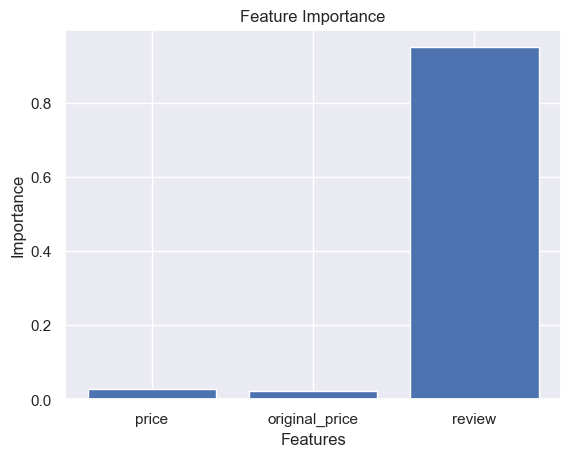

In [109]:
# Define the features and the target
features = ['price', 'original_price', 'review']
X = df[features]
y = df['items_sold']

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the random forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict the test set results
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('Root Mean Squared Error:', rmse)

# Get importance
importance = model.feature_importances_

# Summarize feature importance
for i,j in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (features[i],j))

# Plot feature importance
plt.bar(range(len(features)), importance, tick_label=features)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

The statistics provided give insights into the performance and characteristics of the Random Forest model:

- **Root Mean Squared Error (RMSE)**: The Root Mean Squared Error (RMSE) of the model is 109.57. This means that on average, the model's predictions are about 109.57 units away from the actual values. Considering the scale of the 'items_sold' variable, this error might be considered relatively small. The mean of 'items_sold' is 117.78, so an average error of 109.57 represents a relatively small proportion of this mean. However, the standard deviation is 560.99, which is much larger than the RMSE, indicating that the data has a wide spread and the model's predictions are relatively close to the actual values.
- **Feature Importance**: The feature importance scores indicate the relative importance of each feature in making predictions with the model. In this case, the 'review' feature has the highest importance score (0.95089), suggesting that it is the most important feature for predicting 'items_sold'. The 'price' and 'original_price' features have lower importance scores (0.02705 and 0.02206, respectively), indicating that they are less important for the model's predictions. This could suggest that the number of reviews a product has received is a stronger predictor of how many items will be sold than the product's price or original price

However, it's important to note that feature importance scores can sometimes be misleading, especially when dealing with correlated features or features with different scales. Therefore, these scores should be interpreted with caution and used as one of many tools for understanding the model

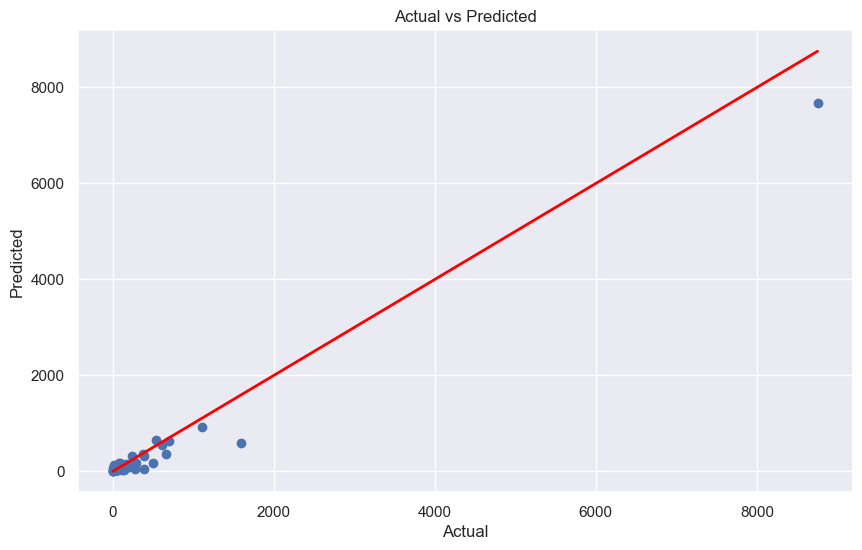

In [110]:
# Convert y_test and y_pred to NumPy arrays
y_test_np = np.array(y_test)
y_pred_np = np.array(y_pred)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_np, y_pred_np)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')

# Plot a line representing perfect prediction
min_val = min(y_test_np.min(), y_pred_np.min())
max_val = max(y_test_np.max(), y_pred_np.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linewidth=2)
plt.show()

The plot illustrates that although the random forest can be relatively accurate with small values, as the values are getting bigger, the variance also increases. This phenomenon is known as heteroscedasticity. This is common in situations where the data spans several orders of magnitude. In the context of a Random Forest model, this could be due to several reasons:
- **Model Complexity**: Random Forests are capable of capturing complex, non-linear relationships, but they might struggle with extreme values or outliers, which could lead to larger errors for larger values
- **Overfitting**: Random Forests can sometimes overfit to the training data, especially if the model is very complex (e.g., if the trees in the forest are very deep). This can lead to larger errors when predicting new data, especially for larger values that are not well-represented in the training data
- **Feature Importance**: If the features that are most important for predicting larger values are not well captured by the model, this could also lead to larger errors for these values

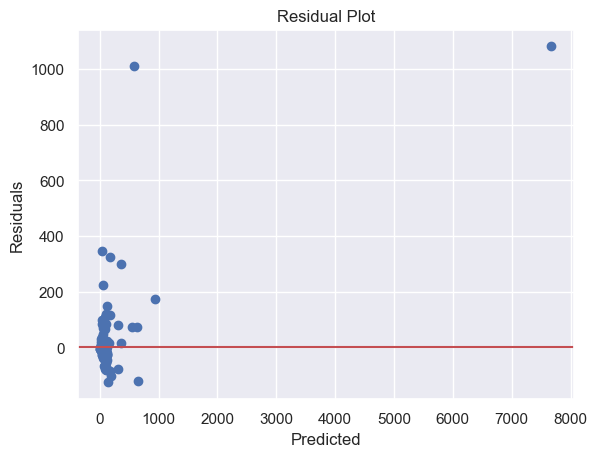

In [111]:
# Calculate the residuals
residuals = y_test - y_pred

# Create a scatter plot of the residuals
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')  # Add a horizontal line at y=0
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

The Residual Plot supports the hypothesis of heteroscedasticity. There are some outliers that the model can not capture accurately. However, the model prediction result is not notably skewed as the residuals spread quite equally at both side of the line.

In [41]:
# Set a random state seed to make the result reproducible
random_state = 42

# Define a list of models
models = [
    SGDRegressor(random_state=random_state),
    Lasso(random_state=random_state),
    ElasticNet(random_state=random_state),
    Ridge(random_state=random_state),
    SVR(),
    BaggingRegressor(random_state=random_state),
    NuSVR(),
    RandomForestRegressor(random_state=random_state)
]

# Define a function to train and evaluate a model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return mse, r2

# Train and evaluate each model
results = []
for model in models:
    mse, r2 = evaluate_model(model, X_train, X_test, y_train, y_test)
    results.append({
        'model': model.__class__.__name__,
        'mse': mse,
        'r_squared': r2
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)

# Find the best model based on MSE
best_model = models[results_df['mse'].idxmin()]

# Display the best model
print("Best model based on MSE:", best_model)

                   model            mse  r_squared
0           SGDRegressor   14052.057218   0.958751
1                  Lasso   13289.527654   0.960990
2             ElasticNet   54205.839215   0.840883
3                  Ridge   14002.761719   0.958896
4                    SVR  341863.991621  -0.003516
5       BaggingRegressor    6420.903515   0.981152
6                  NuSVR  341509.465957  -0.002475
7  RandomForestRegressor   12006.524594   0.964756
Best model based on MSE: BaggingRegressor(random_state=42)


It can be seen that, the best model based on MSE is Bagging Regressor, so, let's see how does it work and how it can outperform Random Forest Classifier in this case
## How Bagging Regressor works:
Bagging Regressor, also known as Bootstrap Aggregating, is a machine learning algorithm that leverages the power of multiple models to improve the accuracy and robustness of predictions. It is an ensemble method that reduces the variance of an estimate by averaging together multiple estimates.
In the context of regression, Bagging Regressor works by creating multiple subsets of the original data, fitting a model to each subset, and then averaging the predictions. Each subset of the original data is created using a process called bootstrapping. This involves randomly sampling the original data with replacement, meaning the same sample can appear more than once in the subset.
The Bagging Regressor then fits a regression model to each of these subsets. The model could be any regression model - for example, a linear regression, a decision tree, or even a neural network. Each model is trained independently of the others, and each makes its own predictions.
The final step in the Bagging Regressor algorithm is to combine the predictions from all the models. This is typically done by averaging the predictions. The idea is that by averaging multiple predictions, the variance of the predictions is reduced, leading to a more robust and accurate final prediction.
One of the key advantages of Bagging Regressor is that it can reduce overfitting, which is a common problem in machine learning where a model performs well on the training data but poorly on new, unseen data. By averaging the predictions from multiple models, Bagging Regressor can create a final prediction that is less likely to overfit to the training data.



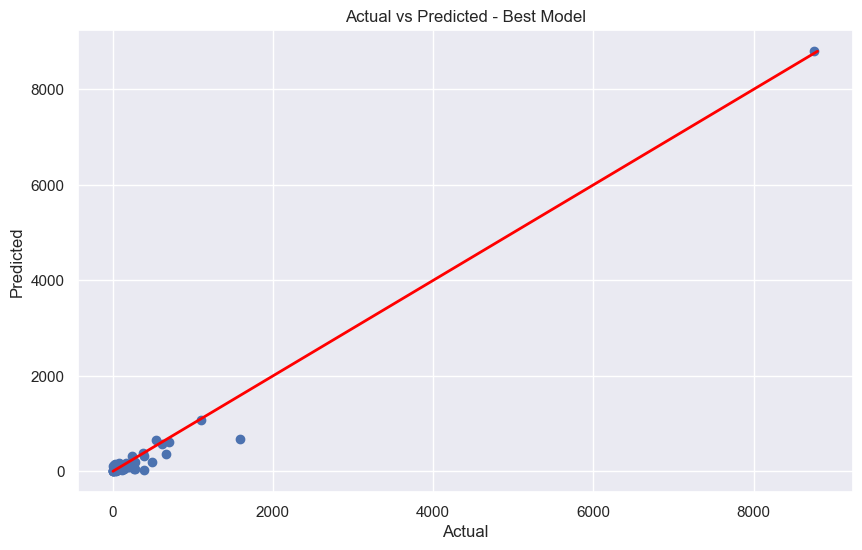

In [116]:
# Predict the test set results with the best model
y_pred_best = best_model.predict(X_test)

# Convert y_test and y_pred to NumPy arrays
y_test_np = np.array(y_test)
y_pred_best_np = np.array(y_pred_best)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_np, y_pred_best_np, label='Data points')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted - Best Model')

# Plot a line representing perfect prediction
min_val = min(y_test_np.min(), y_pred_best_np.min())
max_val = max(y_test_np.max(), y_pred_best_np.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linewidth=2, label='Perfect prediction')
plt.show()

It can be seen from the graph that, the model can accurately predict the outlier more accurately than the Random Forest Regression, since it can accurately capture more values and the outliers than the Random Forest Regression model

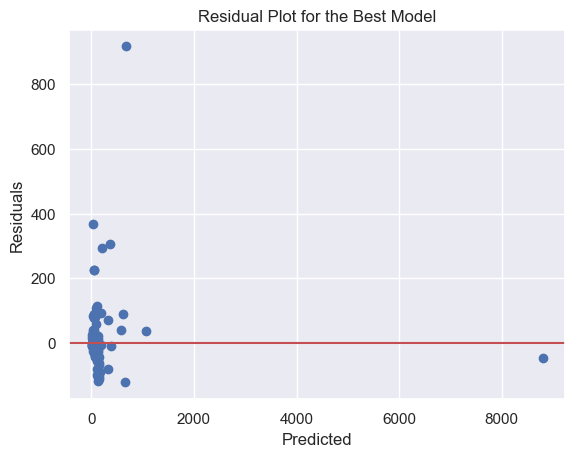

In [117]:
# Calculate the residuals for the best model
residuals_best = y_test - y_pred_best

# Create a scatter plot of the residuals
plt.scatter(y_pred_best, residuals_best)
plt.axhline(y=0, color='r', linestyle='-')  # Add a horizontal line at y=0
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot for the Best Model')
plt.show()

The predicted data inclined to its respective actual ones more in the Bagging Regression model as can be seen on the perfect prediction line. Similarly, the residual terms of the Bagging Regressor model has smaller variation for the empirical distribution in the point zero.
Therefore it can be said that the Bagging Regressor model outperforms the Random Forest model in terms of predictive accuracy. However, be noted that the effectiveness of the model can also be based on how the dataset is split. by changing the variable **random_state**, the best model may be another model. This does not occasionally happen in real life scenarios. Usually, the best model usually stays the same regardless of how the data is split.

### Choosing Lasso as a Standard encometric method for comparison
Lasso, which stands for Least Absolute Shrinkage and Selection Operator, is a regression analysis method that performs both variable selection and regularization. The goal of Lasso is to obtain the subset of predictors that minimizes prediction error for a quantitative response variable. In this project, we are using Lasso as a Standard encometric method for comparison with the Random Forest Model

### How Lasso model works
Lasso, which stands for Least Absolute Shrinkage and Selection Operator, is a regression analysis method that performs both variable selection and regularization. The goal of Lasso is to obtain the subset of predictors that minimizes prediction error for a quantitative response variable. 

The process begins with a standard linear regression model, which assumes a linear relationship between the independent variables (features) and the dependent variable (target). The linear regression equation can be represented as $$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_px_p + \epsilon$$, where $y$ is the dependent variable, $\beta_i$ are the coefficients, and $x_i$ are the independent variables.

The objective of Lasso is to find the values of the coefficients that minimize the sum of the squared differences between the predicted values and the actual values. This is also known as the residual sum of squares (RSS). However, unlike standard linear regression, Lasso adds a penalty term to the objective function. This penalty term is the L1 regularization term, which is the sum of the absolute values of the coefficients multiplied by a regularization parameter $\lambda$. The L1 regularization encourages sparsity in the model by shrinking some coefficients towards zero, effectively performing feature selection.

The choice of $\lambda$ is crucial as it determines the degree of regularization. A larger $\lambda$ value increases the amount of regularization, leading to more coefficients being pushed towards zero. Conversely, a smaller $\lambda$ value reduces the regularization effect, allowing more variables to have non-zero coefficients.

Lasso solves the optimization problem to find the coefficients that minimize the objective function. This can be done using various optimization algorithms, such as coordinate gradient descent or least-angle regression. After the optimization, Lasso selects the features with non-zero coefficients for use in the final model. This results in a sparse model that includes only the most relevant features, improving interpretability and reducing overfitting.

In summary, Lasso works by fitting a linear regression model with an added L1 regularization term. This leads to feature selection and a more interpretable model with improved prediction accuracy.

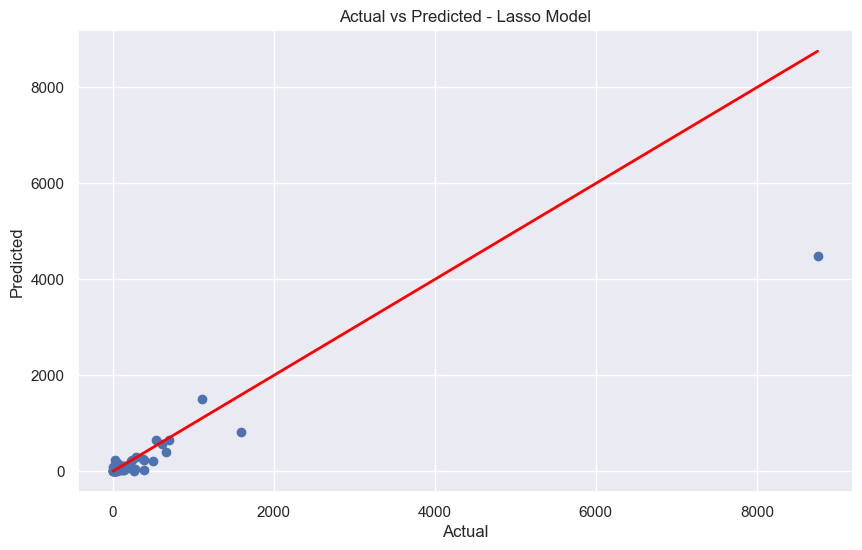

In [42]:
# Lasso model as the econometric model
# Predict the test set results with the best model
y_pred_lasso = model[1].predict(X_test)

# Convert y_test and y_pred to NumPy arrays
y_test_np = np.array(y_test)
y_pred_lasso_np = np.array(y_pred_lasso)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_np, y_pred_lasso_np, label='Data points')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted - Lasso Model')

# Plot a line representing perfect prediction
min_val = min(y_test_np.min(), y_pred_lasso_np.min())
max_val = max(y_test_np.max(), y_pred_lasso_np.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linewidth=2, label='Perfect prediction')
plt.show()

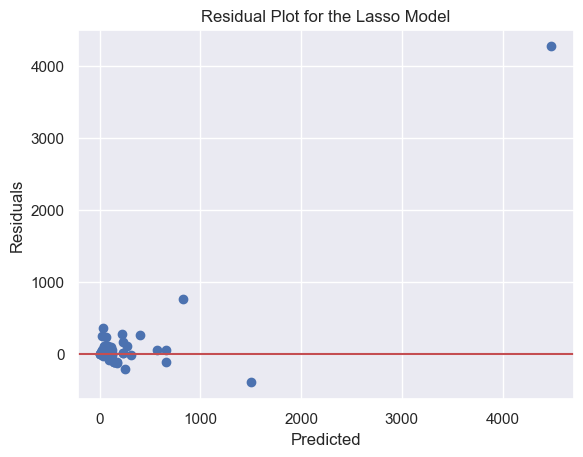

In [43]:
# Calculate the residuals for the lasso model
residuals_lasso = y_test - y_pred_lasso

# Create a scatter plot of the residuals
plt.scatter(y_pred_lasso, residuals_lasso)
plt.axhline(y=0, color='r', linestyle='-')  # Add a horizontal line at y=0
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot for the Lasso Model')
plt.show()

It can be seen that Lasso Model does not predict as accurately as the Random Forest regressor. It has large residuals for outliers and items_sold with large value. The plot is also skewed as the residual plot show that the model is underguessing the value of the data. (It has more positive residuals than negative residuals)

## Tuning the hyperparameters of the Random Forest Regressor model
### What are the hyperparameters?
Hyperparameters are parameters that are not learned from the data. They are set prior to the commencement of the learning process and determine the structure and/or behavior of the learning algorithm. While the model learns the parameters from the data during training, hyperparameters are usually set manually and tuned for optimal performance.

### How to tune the hyperparameters
We use GridSearchCV to optimize the hyperparameters of a RandomForestRegressor model because it automates the process of finding the optimal hyperparameters for a model, which can significantly improve the model's performance. First, a parameter grid is defined, which is a dictionary containing the hyperparameters to be tuned and their respective ranges. In this case, the hyperparameters are 'n_estimators', 'max_depth', 'min_samples_split', and 'min_samples_leaf'. In a Random Forest model, these hyperparameters play crucial roles in determining the model's performance.
- **'n_estimators'**: This hyperparameter specifies the number of trees in the forest of the model. The larger the number of trees, the better the model learns the data. However, adding a lot of trees can slow down the training process considerably, hence one needs to balance the need for more trees with the computational cost.
- **'max_depth'**: This parameter determines the maximum depth of each tree. The deeper the tree, the more splits it has, and it captures more information about the data. However, too much depth can lead to overfitting, where the model learns the training data too well and performs poorly on unseen data.
- **'min_samples_split'**: This hyperparameter defines the minimum number of samples (or observations) which are required in a node to be considered for splitting. It helps control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
- **'min_samples_leaf'**: This parameter specifies the minimum number of samples required to be at a leaf node. Smaller leaf size makes the model more prone to capturing noise in train data. Generally, lower values should be chosen for imbalanced class problems because the regions in which the minority class will be in the majority will be very small.

A baseline RandomForestRegressor model is then created, which serves as the estimator for the GridSearchCV. The GridSearchCV object is instantiated with the estimator, parameter grid, cross-validation strategy (cv=3), and other settings such as 'n_jobs' and 'verbose'.
* **'n_jobs'**: This parameter tells the engine how many processors it is allowed to use. A value of "-1" means that there is no limit, while a value of "1" means that it can only use one processor. This parameter can be crucial in large datasets or complex computations as it allows for parallel processing, which can significantly speed up the computation time.
* **'verbose'**: This is a general programming term that means "providing a lot of information or detail". In the context of GridSearchCV, it controls the verbosity of the messages that are output during the model fitting process. The higher the number, the more messages are output. A value of 0 means no messages, 1 means only important messages, and 2 or more means more detailed messages. This can be useful for understanding the progress and debugging.

In the provided code, 'n_jobs' is set to -1, which means the computation is performed using all available processors to speed up the process. 'verbose' is set to 2, which means detailed messages are output during the model fitting process, providing insights into what the model is doing
The GridSearchCV object is fitted to the training data, which initiates the search for the best combination of hyperparameters. GridSearchCV systematically explores each combination of hyperparameters, fitting a model and evaluating it using cross-validation. The combination that results in the best cross-validation score is identified as the best parameters.

Once the best parameters are found, a new RandomForestRegressor model is created using these parameters and fitted to the training data. The model's performance is evaluated using cross-validation, and the cross-validation scores are printed.
Additionally, the feature importances of the model are displayed, providing insights into which features are most important in predicting 'items_sold'.
Finally, the code includes a comparison with a RandomForestRegressor model that uses the default hyperparameters. This allows the user to see the improvement in performance that results from tuning the hyperparameters using GridSearchCV.

In [44]:
# Define the parameter grid for GridSearch
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a baseline model
rf = RandomForestRegressor(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model using the best parameters
best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Evaluate the model using cross_val_score
scores = cross_val_score(best_rf, X_train, y_train, cv=5)
print("Cross-validation scores: ", scores)
print("Average cross-validation score: ", scores.mean())

# Display feature importance
importances = best_rf.feature_importances_
for feature, importance in zip(['price', 'original_price', 'review'], importances):
    print(f'Feature: {feature}, Importance: {importance}')

# Compare with the previous RandomForestRegressor
previous_rf = RandomForestRegressor(n_estimators=100, random_state=42)
previous_rf.fit(X_train, y_train)

prev_scores = cross_val_score(previous_rf, X_train, y_train, cv=5)
print("Previous RF cross-validation scores: ", prev_scores)
print("Average previous RF cross-validation score: ", prev_scores.mean())

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Cross-validation scores:  [0.658983   0.78827426 0.74792899 0.83167078 0.83084655]
Average cross-validation score:  0.7715407167820425
Feature: price, Importance: 0.010167709741224955
Feature: original_price, Importance: 0.008275970116462689
Feature: review, Importance: 0.9815563201423123
Previous RF cross-validation scores:  [0.59679631 0.70856061 0.60875768 0.74800339 0.77561422]
Average previous RF cross-validation score:  0.6875464422911717


### Explanation on the result:
* **'cross_val_score'** is a function in the sklearn.model_selection module of the Scikit-learn library in Python. It is used to evaluate a machine learning model using cross-validation. Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into.
The cross_val_score function splits the dataset into a specified number of "folds", trains the model on some of these folds, and then tests the model on the remaining fold. This process is repeated so that each fold of the dataset is used for testing at some point. The function returns a list of scores, one for each iteration of the cross-validation procedure.
In the provided results, cross_val_score was used to evaluate a model five times (as indicated by the five scores). The scores are measures of the model's accuracy and can range from 0 to 1, with 1 being perfect accuracy. The average of these scores is then calculated, providing a single measure of the model's average accuracy across the five iterations of cross-validation.

The results show that the optimized model's average cross-validation score is approximately 0.772, which indicates a fairly high level of accuracy. The model's feature importances are also provided, showing the relative importance of each feature used in the model. The 'review' feature has the highest importance, followed by 'price' and 'original_price'.

The "previous RF cross-validation scores" refer to the cross-validation scores from the previous run of the model, with default hyperparameters. The average of these scores is approximately 0.688, which is lower than the current average score, suggesting that the model's performance has improved.

In [45]:
#Showing the best parameters
best_params

{'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

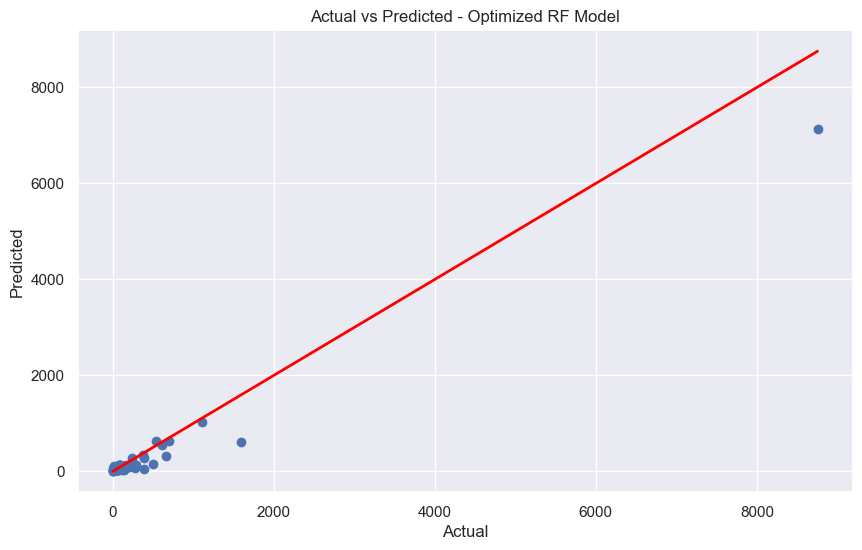

In [46]:
# Predict the test set results with hyperparameter tuning
y_pred_best = best_rf.predict(X_test)

# Convert y_test and y_pred to NumPy arrays
y_test_np = np.array(y_test)
y_pred_best_np = np.array(y_pred_best)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_np, y_pred_best_np, label='Data points')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted - Optimized RF Model')

# Plot a line representing perfect prediction
min_val = min(y_test_np.min(), y_pred_best_np.min())
max_val = max(y_test_np.max(), y_pred_best_np.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linewidth=2, label='Perfect prediction')
plt.show()

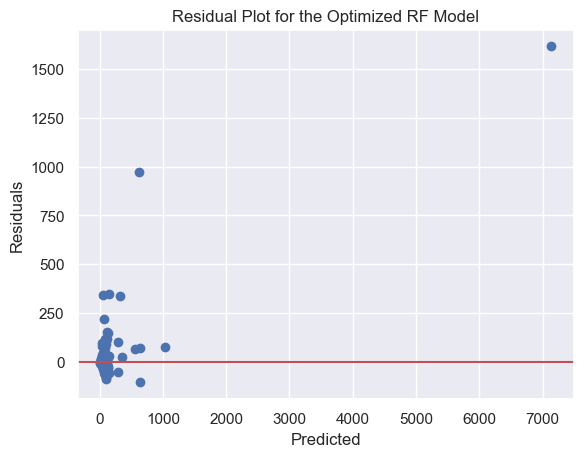

In [47]:
# Calculate the residuals for the optimized RF model
residuals_best_rf = y_test - y_pred_best

# Create a scatter plot of the residuals
plt.scatter(y_pred_best, residuals_best_rf)
plt.axhline(y=0, color='r', linestyle='-')  # Add a horizontal line at y=0
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot for the Optimized RF Model')
plt.show()

It can be seen that the Optimized RF model performs similarly to the original Random Forest Regression model. The residual plot shows a slight skew of the model, indicating that it is underguessing the values. The model cannot capture the outliers, similar to the orginal model. This can be due to the nature of the data. In reality, the optimized RF model usually performs better with the optimal hyperparameters.

# Part 6: Making the Random Forest Model from scratch

We are going to attepmt to create a Random Forest algorithm from scratch. Instead of building everything from scratch, we are going to make use of the Decision Tree Regressor from the sklearn library and develop a Random Forest Regressor. Here's a step-by-step explanation of the code:

1. **Initialization**: When an instance of the RandomForest class is created, it is initialized with the number of trees (n_trees), maximum depth of the trees (max_depth), minimum number of samples required to split an internal node (min_samples_split), and the number of features to consider when looking for the best split (n_features). These are hyperparameters for the Random Forest algorithm.
2. **Fitting the model**: The fit method is used to train the model. It first converts the input data (X_train and y_train) to numpy arrays. Then, for each tree in the forest, it creates a bootstrap sample of the training data, fits a DecisionTreeRegressor to this sample, and adds the fitted tree to the list of trees.
3. **Creating bootstrap samples**: The _bootstrap_samples method is used to create a bootstrap sample of the training data. It does this by randomly selecting samples from the training data with replacement, meaning that the same sample can be selected more than once.
4. **Making predictions**: The predict method is used to make predictions on new data (X_test). It does this by making predictions with each tree in the forest and then averaging these predictions.
5. **Calculating the Mean Squared Error (MSE) and R^2 score**: After making predictions, the mean_squared_error and r2_score functions defined earlier to calculate the MSE and R^2 score, respectively. The MSE is a measure of the average squared difference between the actual and predicted values, while the R^2 score is a measure of how well the model's predictions fit the actual values.

In [124]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from collections import Counter

class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_feature=None):
        # Initialize the RandomForest with the given hyperparameters
        self.n_trees = n_trees
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.n_features=n_feature
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        X = np.array(X)  # Convert X to a numpy array
        y = np.array(y)  # Convert y to a numpy array
        for _ in range(self.n_trees):
            # Create a DecisionTreeRegressor and fit it to a bootstrap sample of the data
            tree = DecisionTreeRegressor(max_depth=self.max_depth,
                            min_samples_split=self.min_samples_split)
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_samples(self, X, y): # Create a bootstrap sample of the data
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def _most_common_label(self, y): # takes a list of labels y as input and returns the most common label in that list.
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X): # Make predictions by averaging the predictions of all trees
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([np.mean(pred) for pred in tree_preds])
        return predictions
    
# Create an instance of the RandomForest class
rf = RandomForest(n_trees=100, max_depth=10, min_samples_split=2)

# Fit the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Calculate the MSE and R^2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 7283.208735905153
R^2 Score: 0.9786206994870946


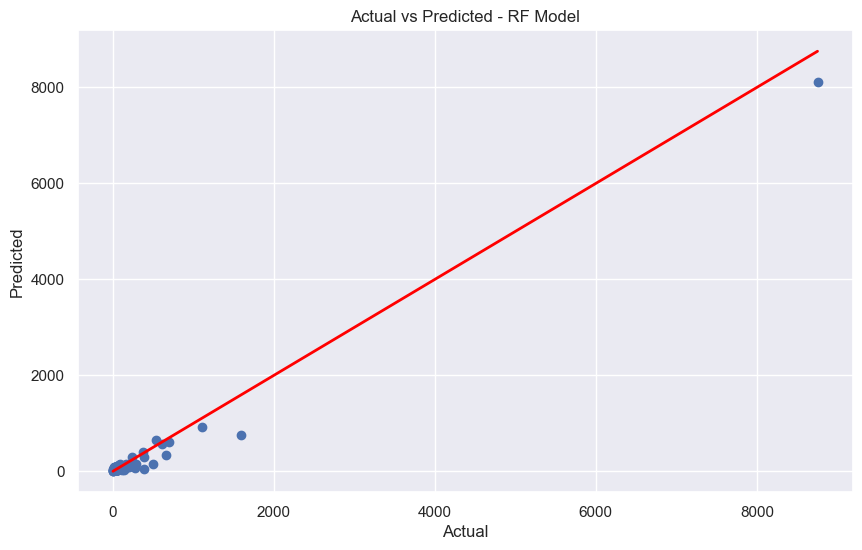

In [126]:
# Predict the test set results with the self made RF model
y_pred_rf2 = rf.predict(X_test)

# Convert y_test and y_pred to NumPy arrays
y_test_np = np.array(y_test)
y_pred_rf2_np = np.array(y_pred_rf2)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_np, y_pred_rf2_np, label='Data points')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted - RF Model')

# Plot a line representing perfect prediction
min_val = min(y_test_np.min(), y_pred_rf2_np.min())
max_val = max(y_test_np.max(), y_pred_rf2_np.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linewidth=2, label='Perfect prediction')
plt.show()

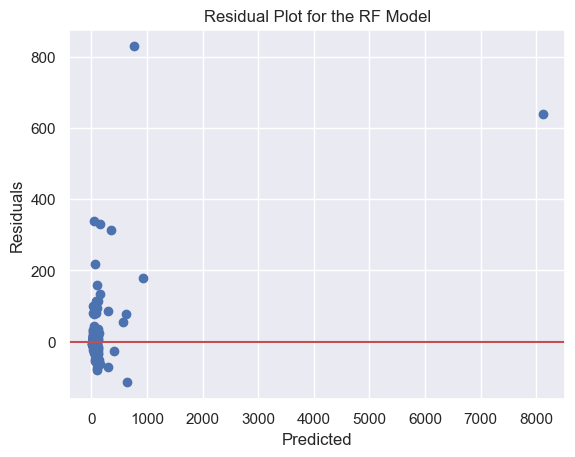

In [127]:
# Calculate the residuals for the self made model
residuals_rf2 = y_test - y_pred_rf2

# Create a scatter plot of the residuals
plt.scatter(y_pred_rf2, residuals_rf2)
plt.axhline(y=0, color='r', linestyle='-')  # Add a horizontal line at y=0
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot for the RF Model')
plt.show()

It can be seen that the self made model performs slightly better than the original model. With more accurate prediction for outliers. Although the prediction is slightly skewed, but the skewness is not notable.